# Imports

In [1]:
from utils import *
SEED = 0

# Parámetros

In [2]:
# WGAN
N_EPOCHS = 20
N_CRITIC = 5
LAMBDA_GP = 0.5
BATCH_SIZE = 128
LATENT_DIM = 1
CONDITION_DIM = 1
INPUT_DIM = 1
G_HIDDEN_LAYERS = 4
G_HIDDEN_DIM = 16
G_LEAKY_RELU = 0.1
D_HIDDEN_LAYERS = 2
D_HIDDEN_DIM = 64
D_DROPOUT = 0.4
D_LEAKY_RELU = 0.1
LR_GEN = 0.0002
LR_DIS = 0.0002
B1 = 0.5
B2 = 0.999

# Simulaciones

In [3]:
# Para generación de datos
VARS = ['var1']
T = 20
H_STEPS = 5
TIME_PERIODS = np.arange(T)
PREDICT_RANGE = range(T, T+H_STEPS)
N_SAMPLES = 1000

## Normal univariada

### Datos

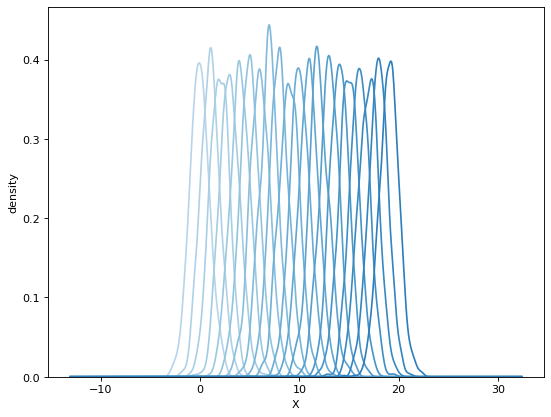

In [4]:
np.random.seed(SEED)

sigma = 1
offset = 10

# Genero observaciones
data = []

for t in TIME_PERIODS:
  samples = np.random.normal(loc=t, scale=sigma, size=[N_SAMPLES,len(VARS)])
  samples = pd.DataFrame(samples, columns = VARS)
  samples['time'] = t
  data.append(samples)

data = pd.concat(data, ignore_index=True)

# Ajusto KDEs
kdes = get_kdes(data, VARS[0], 'time', TIME_PERIODS)

grid_points = np.linspace(data.var1.min()-offset, data.var1.max()+offset, 1000)
data_matrix = [kdes[t].score_samples(grid_points.reshape(-1,1)) for t in TIME_PERIODS]

plt.figure(figsize=(8, 6), dpi=80)

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')

plt.show()

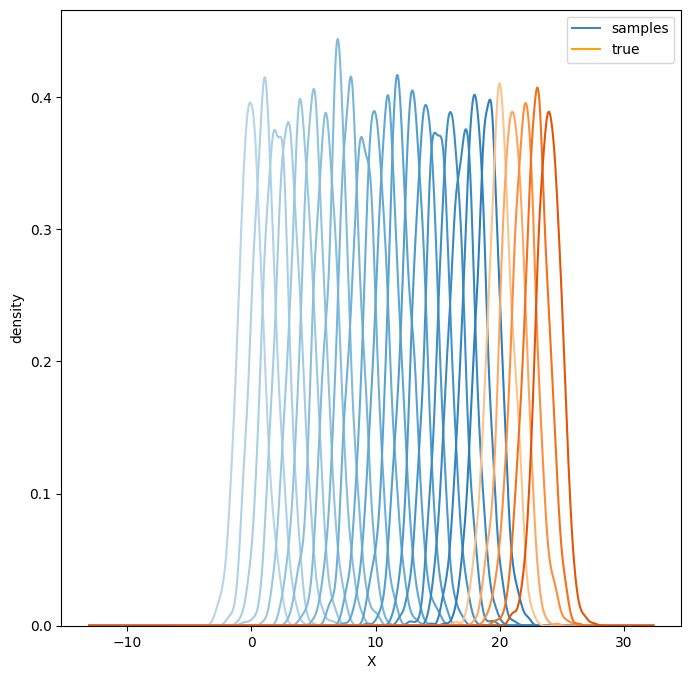

In [5]:
true = []

for t in PREDICT_RANGE:
  samples = np.random.normal(loc=t, scale=sigma, size=[N_SAMPLES, len(VARS)])
  samples = pd.DataFrame(samples, columns=VARS)
  samples['time'] = t
  true.append(samples)

true = pd.concat(true, ignore_index=True)

true_kdes = get_kdes(true, VARS[0], 'time', PREDICT_RANGE)

true_data_matrix = [true_kdes[t].score_samples(grid_points.reshape(-1,1)) for t in PREDICT_RANGE]

plt.figure(figsize=(8, 8), dpi=100)

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

for i, d in zip(np.linspace(0.3,0.7, H_STEPS), true_data_matrix):
  plt.plot(grid_points, np.exp(d), color=ORANGE(i))

plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='true')
plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')
plt.legend()
plt.show()

### Paramétrico

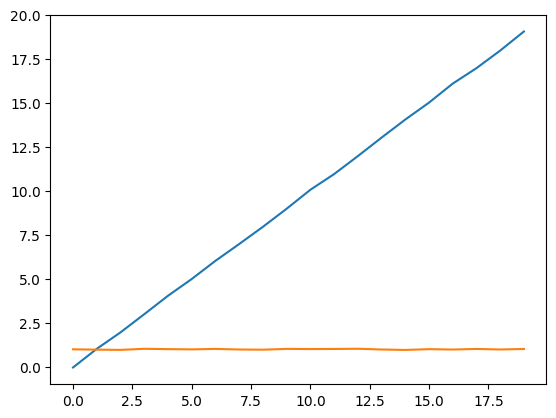

In [6]:
parameters = pd.DataFrame(
                [norm.fit(data.loc[data.time == t, 'var1']) for t in TIME_PERIODS],
                columns = ['mu','sigma']
                )

plt.plot(parameters)
plt.show()

In [7]:
fit_mean = FitData('lin')
fit_mean.fit(TIME_PERIODS, parameters.mu)

pred = pd.DataFrame(
    {
        'mu': fit_mean.predict(H_STEPS),
        'sigma': parameters['sigma'].mean(),
        't': range(T,T+H_STEPS)
    }
)

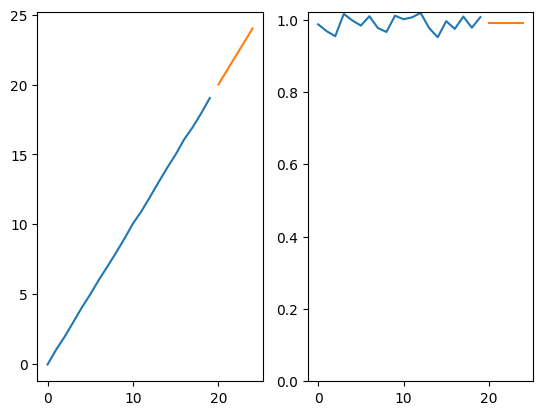

In [8]:
plt.figure(dpi=100)

plt.subplot(1,2,1)
plt.plot(parameters.mu)
plt.plot(pred.set_index('t').mu)

plt.subplot(1,2,2)
plt.plot(parameters.sigma)
plt.plot(pred.set_index('t').sigma)
plt.gca().set_ylim(bottom=0)

plt.show()

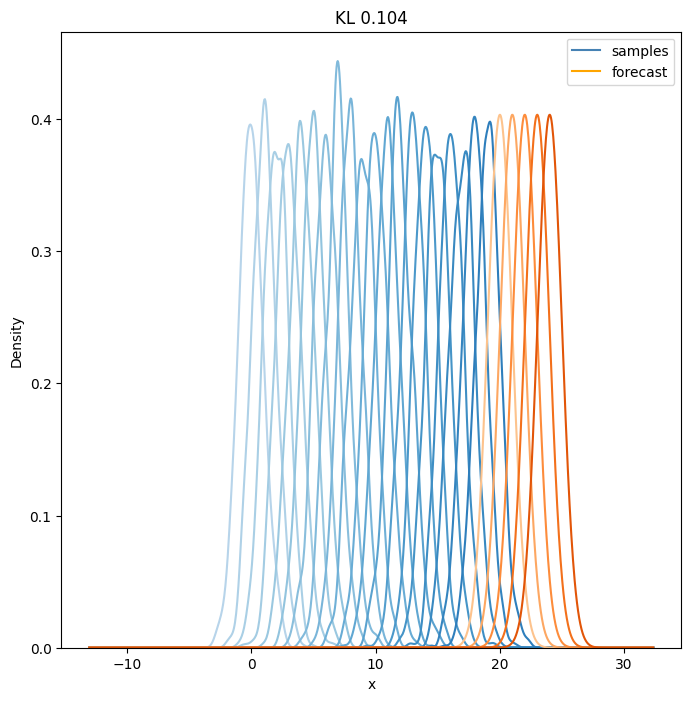

In [9]:
plt.figure(dpi=100, figsize=(8,8))

for i, p in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(p), color=BLUE(i))

preds = [norm.pdf(grid_points, loc=row.mu, scale=row.sigma) for _,row in pred.iterrows()]

kls_p = [get_kl( preds[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_p = np.mean(kls_p)

for i, p in zip(np.linspace(0.3,0.7, H_STEPS), preds):
  plt.plot(grid_points, p, color=ORANGE(i))
plt.title(f'KL {np.round(kl_p,2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

### FPCA

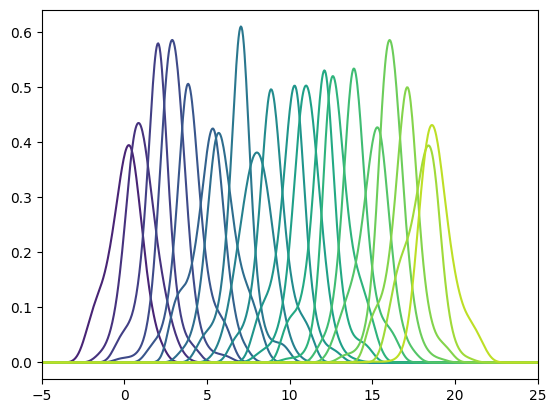

In [10]:
fpca_1n = Fpca(data_matrix, grid_points, n_basis=30)

for n, i in zip(np.linspace(0.1,0.9,T), TIME_PERIODS):
  plt.plot(grid_points, np.exp(fpca_1n.fd[i](grid_points).reshape(-1)), color=VIRIDIS(n))
plt.xlim((-5,25))
plt.show()

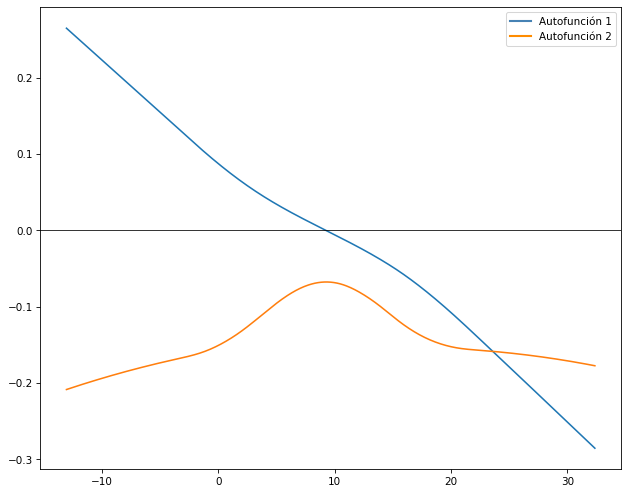

In [11]:
fpca_1n.fit_fpca(n_components=2)

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2)]

ax = plt.figure(dpi=75, figsize=(10,8))
fpca_1n.fpca.components_.plot(ax)
plt.axhline(0, color='black', linewidth=0.75)
plt.legend(custom_lines, ['Autofunción 1', 'Autofunción 2'])
plt.show()

In [12]:
print(fpca_1n.fpca.explained_variance_ratio_)
print(fpca_1n.fpca.explained_variance_ratio_.sum())

[0.94921658 0.0490475 ]
0.9982640837222809


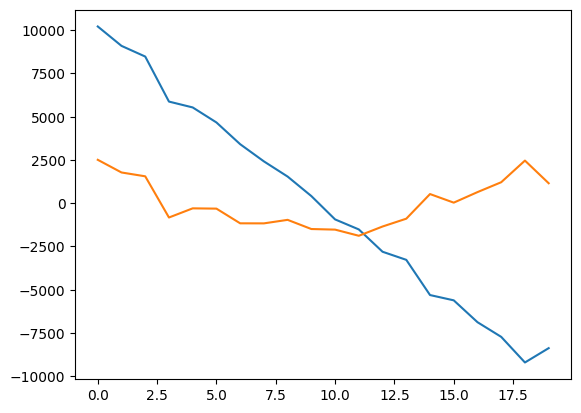

In [13]:
plt.plot(fpca_1n.scores)
plt.show()

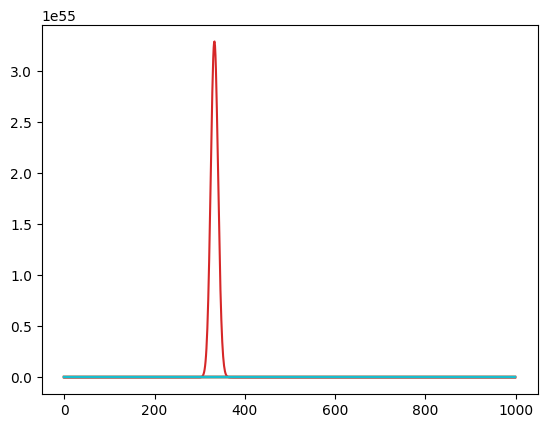

In [14]:
for i in TIME_PERIODS:
  plt.plot(np.exp(fpca_1n.results[i]))
plt.show()

In [15]:
models = {}

models[0] = FitData('lin')
models[0].fit(TIME_PERIODS, fpca_1n.scores[:,0])

models[1] = FitData('poly', degree=2)
models[1].fit(TIME_PERIODS, fpca_1n.scores[:,1])

fpca_1n.fit_time_series(models=models, h_steps=H_STEPS)

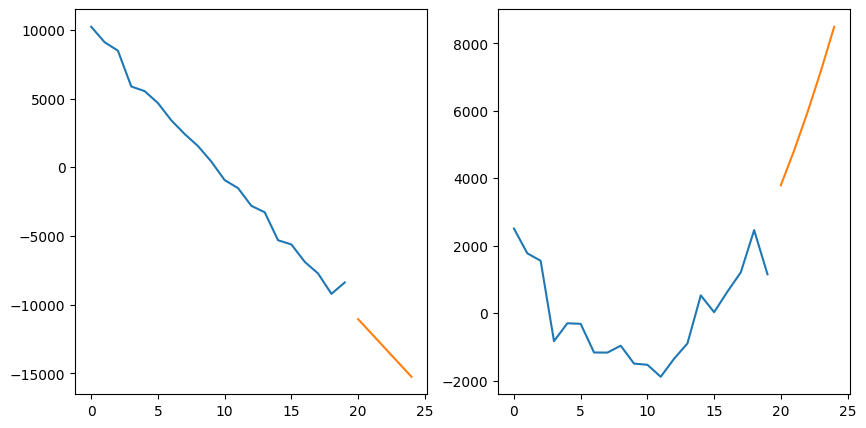

In [16]:
plt.figure(dpi=100, figsize=(10,5))

n_cols = int(np.ceil(np.sqrt(fpca_1n.n_components)))
n_rows = int(np.ceil(fpca_1n.n_components / n_cols))

for i in range(fpca_1n.n_components):
  plt.subplot(n_rows,n_cols,i+1)
  plt.plot(fpca_1n.scores[:,i])
  pred_plot = pd.DataFrame(fpca_1n.pred_w[:,i], index=np.arange(H_STEPS) + len(fpca_1n.scores))
  plt.plot(pred_plot)

plt.show()

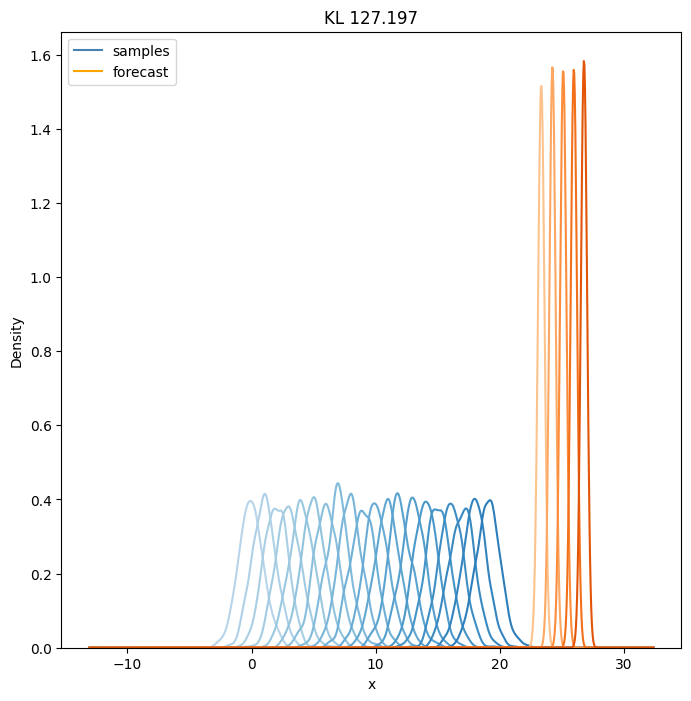

In [17]:
fpca_1n.predict(exp=True, normalize=True)

plt.figure(dpi=100, figsize=(8,8))

for n, i in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(i), color=BLUE(n))

kls_f = [get_kl( fpca_1n.pred_f[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_f = np.mean(kls_f)

for n, i in zip( np.linspace(0.3 ,0.7 , H_STEPS), fpca_1n.pred_f):
  plt.plot(grid_points, i, color=ORANGE(n))
plt.title(f'KL {np.round(kl_f, 2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

### WGAN

In [18]:
np.random.seed(SEED)
torch.manual_seed(SEED)

wgan_1n = Wgan(data = data,
               vars = VARS,
               latent_dim = LATENT_DIM,
               condition_dim = CONDITION_DIM,
               g_hidden_layers = G_HIDDEN_LAYERS,
               g_hidden_dim = G_HIDDEN_DIM,
               g_leaky_relu = G_LEAKY_RELU,
               d_hidden_layers = D_HIDDEN_LAYERS,
               d_hidden_dim = D_HIDDEN_DIM,
               d_dropout = D_DROPOUT,
               d_leaky_relu = D_LEAKY_RELU,
               input_dim = INPUT_DIM,
               lr_gen = LR_GEN,
               lr_dis = LR_DIS,
               b1 = B1,
               b2 = B2,
               lambda_gp = LAMBDA_GP,
               n_critic = N_CRITIC,
               batch_size = BATCH_SIZE,
               device = DEVICE)

[0/2000]: loss_d: 0.365, loss_g: -0.451


15.0


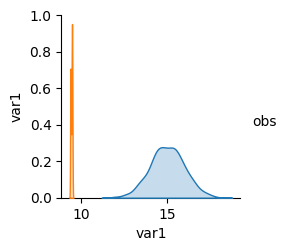

[10/2000]: loss_d: -0.358, loss_g: -0.184
[20/2000]: loss_d: 0.025, loss_g: -0.478
[30/2000]: loss_d: -0.247, loss_g: -0.310
[40/2000]: loss_d: -0.291, loss_g: -0.306
[50/2000]: loss_d: -0.280, loss_g: -0.327


11.0


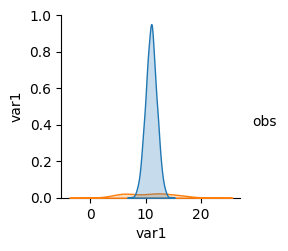

[60/2000]: loss_d: 0.173, loss_g: -0.420
[70/2000]: loss_d: 0.170, loss_g: -0.410
[80/2000]: loss_d: 0.134, loss_g: -0.439
[90/2000]: loss_d: 0.111, loss_g: -0.488
[100/2000]: loss_d: 0.106, loss_g: -0.500


11.0


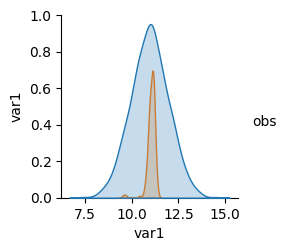

[110/2000]: loss_d: 0.097, loss_g: -0.478
[120/2000]: loss_d: 0.106, loss_g: -0.444
[130/2000]: loss_d: 0.091, loss_g: -0.438
[140/2000]: loss_d: 0.102, loss_g: -0.367
[150/2000]: loss_d: 0.104, loss_g: -0.384


6.0


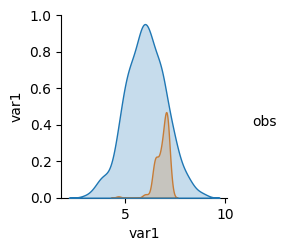

[160/2000]: loss_d: 0.111, loss_g: -0.372
[170/2000]: loss_d: 0.120, loss_g: -0.353
[180/2000]: loss_d: 0.111, loss_g: -0.370
[190/2000]: loss_d: 0.112, loss_g: -0.372
[200/2000]: loss_d: 0.107, loss_g: -0.380


1.0


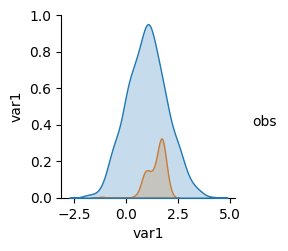

[210/2000]: loss_d: 0.126, loss_g: -0.387
[220/2000]: loss_d: 0.138, loss_g: -0.380
[230/2000]: loss_d: 0.127, loss_g: -0.399
[240/2000]: loss_d: 0.106, loss_g: -0.402
[250/2000]: loss_d: 0.161, loss_g: -0.361


19.0


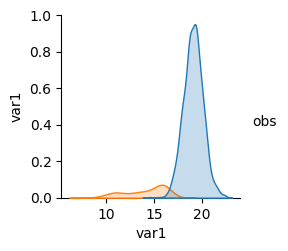

[260/2000]: loss_d: 0.140, loss_g: -0.421
[270/2000]: loss_d: 0.160, loss_g: -0.381
[280/2000]: loss_d: 0.158, loss_g: -0.391
[290/2000]: loss_d: 0.164, loss_g: -0.400
[300/2000]: loss_d: 0.208, loss_g: -0.384


15.0


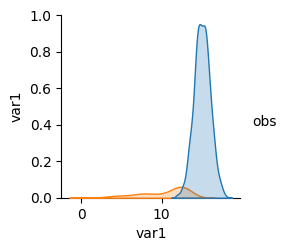

[310/2000]: loss_d: 0.140, loss_g: -0.442
[320/2000]: loss_d: 0.133, loss_g: -0.387
[330/2000]: loss_d: 0.184, loss_g: -0.380
[340/2000]: loss_d: 0.190, loss_g: -0.393
[350/2000]: loss_d: 0.125, loss_g: -0.465


11.0


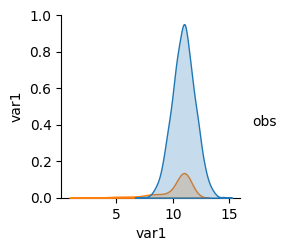

[360/2000]: loss_d: 0.103, loss_g: -0.438
[370/2000]: loss_d: 0.086, loss_g: -0.455
[380/2000]: loss_d: 0.135, loss_g: -0.346
[390/2000]: loss_d: 0.139, loss_g: -0.393
[400/2000]: loss_d: 0.124, loss_g: -0.397


0.0


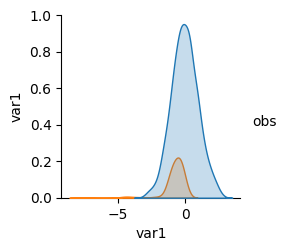

[410/2000]: loss_d: 0.118, loss_g: -0.423
[420/2000]: loss_d: 0.182, loss_g: -0.354
[430/2000]: loss_d: 0.151, loss_g: -0.404
[440/2000]: loss_d: 0.192, loss_g: -0.351
[450/2000]: loss_d: 0.176, loss_g: -0.394


17.0


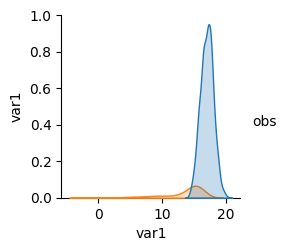

[460/2000]: loss_d: 0.175, loss_g: -0.405
[470/2000]: loss_d: 0.194, loss_g: -0.399
[480/2000]: loss_d: 0.149, loss_g: -0.433
[490/2000]: loss_d: 0.204, loss_g: -0.373
[500/2000]: loss_d: 0.209, loss_g: -0.402


7.0


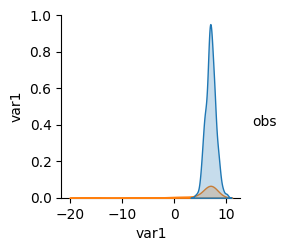

[510/2000]: loss_d: 0.219, loss_g: -0.384
[520/2000]: loss_d: 0.182, loss_g: -0.443
[530/2000]: loss_d: 0.143, loss_g: -0.438
[540/2000]: loss_d: 0.314, loss_g: -0.339
[550/2000]: loss_d: 0.203, loss_g: -0.473


9.0


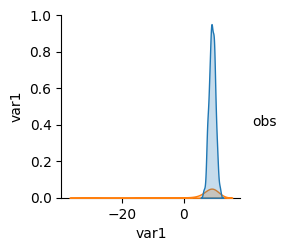

[560/2000]: loss_d: 0.134, loss_g: -0.480
[570/2000]: loss_d: 0.134, loss_g: -0.438
[580/2000]: loss_d: 0.153, loss_g: -0.414
[590/2000]: loss_d: 0.137, loss_g: -0.432
[600/2000]: loss_d: 0.129, loss_g: -0.442


5.0


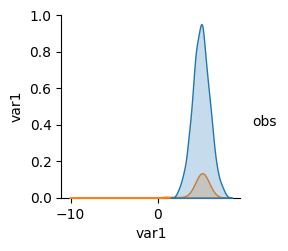

[610/2000]: loss_d: 0.118, loss_g: -0.436
[620/2000]: loss_d: 0.102, loss_g: -0.439
[630/2000]: loss_d: 0.117, loss_g: -0.415
[640/2000]: loss_d: 0.103, loss_g: -0.413
[650/2000]: loss_d: 0.103, loss_g: -0.398


18.0


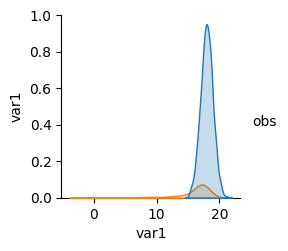

[660/2000]: loss_d: 0.176, loss_g: -0.331
[670/2000]: loss_d: 0.144, loss_g: -0.410
[680/2000]: loss_d: 0.172, loss_g: -0.406
[690/2000]: loss_d: 0.244, loss_g: -0.345
[700/2000]: loss_d: 0.176, loss_g: -0.450


1.0


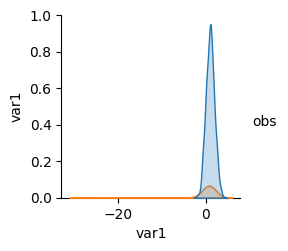

[710/2000]: loss_d: 0.132, loss_g: -0.455
[720/2000]: loss_d: 0.151, loss_g: -0.373
[730/2000]: loss_d: 0.189, loss_g: -0.412
[740/2000]: loss_d: 0.123, loss_g: -0.437
[750/2000]: loss_d: 0.094, loss_g: -0.459


10.0


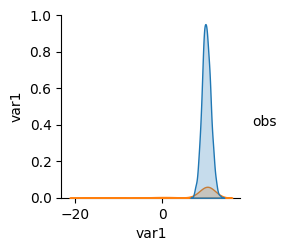

[760/2000]: loss_d: 0.080, loss_g: -0.459
[770/2000]: loss_d: 0.127, loss_g: -0.385
[780/2000]: loss_d: 0.117, loss_g: -0.382
[790/2000]: loss_d: 0.136, loss_g: -0.393
[800/2000]: loss_d: 0.104, loss_g: -0.416


4.0


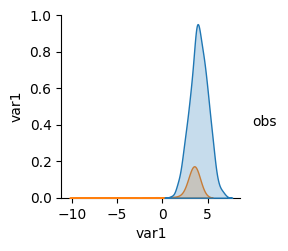

[810/2000]: loss_d: 0.211, loss_g: -0.375
[820/2000]: loss_d: 0.143, loss_g: -0.440
[830/2000]: loss_d: 0.159, loss_g: -0.369
[840/2000]: loss_d: 0.178, loss_g: -0.383
[850/2000]: loss_d: 0.141, loss_g: -0.502


8.0


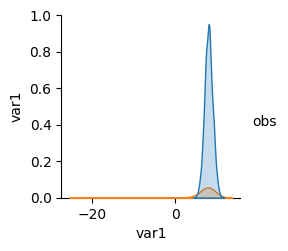

[860/2000]: loss_d: 0.144, loss_g: -0.385
[870/2000]: loss_d: 0.103, loss_g: -0.448
[880/2000]: loss_d: 0.096, loss_g: -0.447
[890/2000]: loss_d: 0.078, loss_g: -0.454
[900/2000]: loss_d: 0.075, loss_g: -0.425


5.0


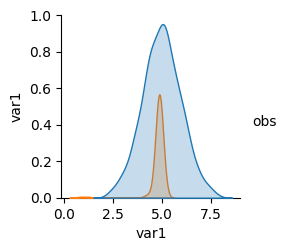

[910/2000]: loss_d: 0.080, loss_g: -0.396
[920/2000]: loss_d: 0.086, loss_g: -0.401
[930/2000]: loss_d: 0.090, loss_g: -0.405
[940/2000]: loss_d: 0.149, loss_g: -0.381
[950/2000]: loss_d: 0.117, loss_g: -0.395


17.0


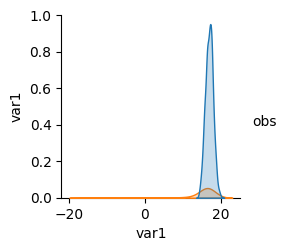

[960/2000]: loss_d: 0.106, loss_g: -0.406
[970/2000]: loss_d: 0.122, loss_g: -0.367
[980/2000]: loss_d: 0.122, loss_g: -0.415
[990/2000]: loss_d: 0.140, loss_g: -0.413
[1000/2000]: loss_d: 0.226, loss_g: -0.315


12.0


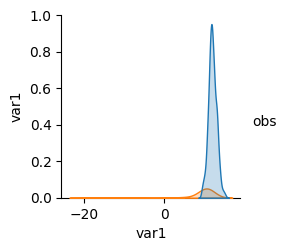

[1010/2000]: loss_d: 0.172, loss_g: -0.412
[1020/2000]: loss_d: 0.152, loss_g: -0.413
[1030/2000]: loss_d: 0.105, loss_g: -0.452
[1040/2000]: loss_d: 0.132, loss_g: -0.372
[1050/2000]: loss_d: 0.151, loss_g: -0.375


10.0


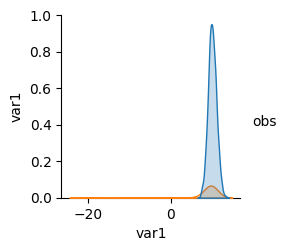

[1060/2000]: loss_d: 0.129, loss_g: -0.424
[1070/2000]: loss_d: 0.217, loss_g: -0.307
[1080/2000]: loss_d: 0.226, loss_g: -0.409
[1090/2000]: loss_d: 0.139, loss_g: -0.522
[1100/2000]: loss_d: 0.090, loss_g: -0.482


18.0


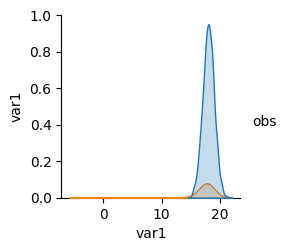

[1110/2000]: loss_d: 0.091, loss_g: -0.411
[1120/2000]: loss_d: 0.090, loss_g: -0.390
[1130/2000]: loss_d: 0.081, loss_g: -0.438
[1140/2000]: loss_d: 0.080, loss_g: -0.414
[1150/2000]: loss_d: 0.137, loss_g: -0.395


15.0


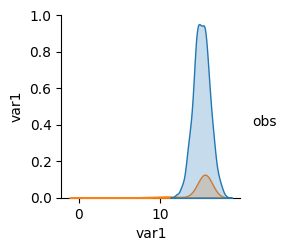

[1160/2000]: loss_d: 0.104, loss_g: -0.425
[1170/2000]: loss_d: 0.167, loss_g: -0.315
[1180/2000]: loss_d: 0.130, loss_g: -0.393
[1190/2000]: loss_d: 0.095, loss_g: -0.452
[1200/2000]: loss_d: 0.083, loss_g: -0.417


19.0


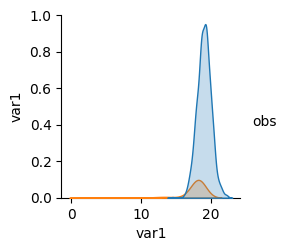

[1210/2000]: loss_d: 0.109, loss_g: -0.404
[1220/2000]: loss_d: 0.084, loss_g: -0.432
[1230/2000]: loss_d: 0.109, loss_g: -0.395
[1240/2000]: loss_d: 0.086, loss_g: -0.425
[1250/2000]: loss_d: 0.108, loss_g: -0.370


2.0


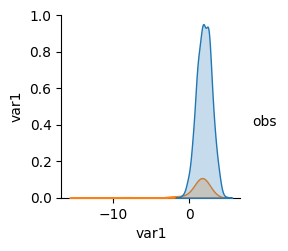

[1260/2000]: loss_d: 0.114, loss_g: -0.382
[1270/2000]: loss_d: 0.084, loss_g: -0.448
[1280/2000]: loss_d: 0.080, loss_g: -0.437
[1290/2000]: loss_d: 0.105, loss_g: -0.377
[1300/2000]: loss_d: 0.091, loss_g: -0.407


2.0


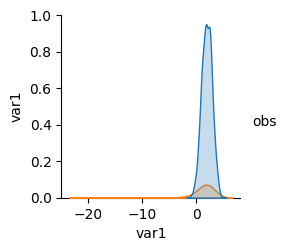

[1310/2000]: loss_d: 0.137, loss_g: -0.343
[1320/2000]: loss_d: 0.105, loss_g: -0.431
[1330/2000]: loss_d: 0.086, loss_g: -0.446
[1340/2000]: loss_d: 0.080, loss_g: -0.424
[1350/2000]: loss_d: 0.083, loss_g: -0.416


0.0


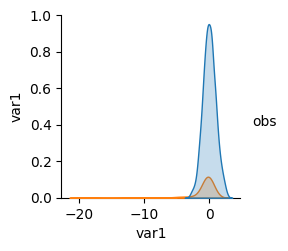

[1360/2000]: loss_d: 0.084, loss_g: -0.393
[1370/2000]: loss_d: 0.073, loss_g: -0.414
[1380/2000]: loss_d: 0.074, loss_g: -0.412
[1390/2000]: loss_d: 0.090, loss_g: -0.400
[1400/2000]: loss_d: 0.105, loss_g: -0.408


19.0


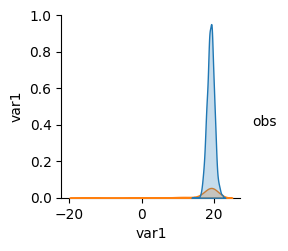

[1410/2000]: loss_d: 0.089, loss_g: -0.407
[1420/2000]: loss_d: 0.094, loss_g: -0.400
[1430/2000]: loss_d: 0.091, loss_g: -0.408
[1440/2000]: loss_d: 0.086, loss_g: -0.409
[1450/2000]: loss_d: 0.080, loss_g: -0.414


3.0


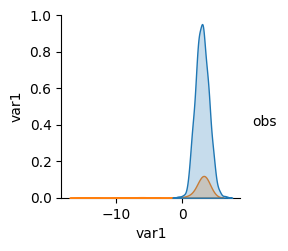

[1460/2000]: loss_d: 0.072, loss_g: -0.421
[1470/2000]: loss_d: 0.070, loss_g: -0.420
[1480/2000]: loss_d: 0.070, loss_g: -0.410
[1490/2000]: loss_d: 0.072, loss_g: -0.421
[1500/2000]: loss_d: 0.072, loss_g: -0.408


9.0


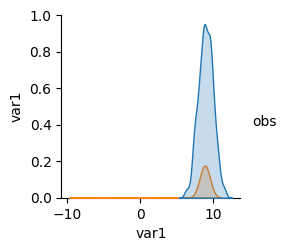

[1510/2000]: loss_d: 0.069, loss_g: -0.425
[1520/2000]: loss_d: 0.069, loss_g: -0.410
[1530/2000]: loss_d: 0.076, loss_g: -0.410
[1540/2000]: loss_d: 0.072, loss_g: -0.430
[1550/2000]: loss_d: 0.095, loss_g: -0.396


11.0


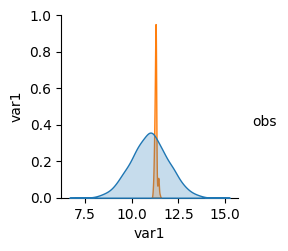

[1560/2000]: loss_d: 0.093, loss_g: -0.408
[1570/2000]: loss_d: 0.112, loss_g: -0.465
[1580/2000]: loss_d: 0.110, loss_g: -0.436
[1590/2000]: loss_d: 0.079, loss_g: -0.437
[1600/2000]: loss_d: 0.073, loss_g: -0.425


1.0


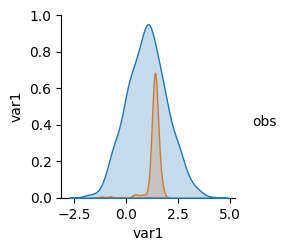

[1610/2000]: loss_d: 0.103, loss_g: -0.327
[1620/2000]: loss_d: 0.071, loss_g: -0.384
[1630/2000]: loss_d: 0.068, loss_g: -0.396
[1640/2000]: loss_d: 0.092, loss_g: -0.319
[1650/2000]: loss_d: 0.073, loss_g: -0.387


8.0


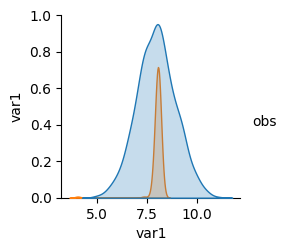

[1660/2000]: loss_d: 0.075, loss_g: -0.387
[1670/2000]: loss_d: 0.111, loss_g: -0.325
[1680/2000]: loss_d: 0.087, loss_g: -0.412
[1690/2000]: loss_d: 0.106, loss_g: -0.369
[1700/2000]: loss_d: 0.160, loss_g: -0.308


19.0


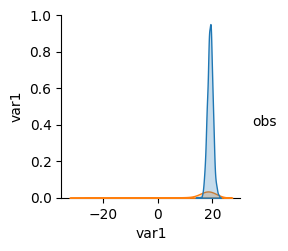

[1710/2000]: loss_d: 0.158, loss_g: -0.411
[1720/2000]: loss_d: 0.151, loss_g: -0.456
[1730/2000]: loss_d: 0.116, loss_g: -0.434
[1740/2000]: loss_d: 0.097, loss_g: -0.414
[1750/2000]: loss_d: 0.090, loss_g: -0.409


7.0


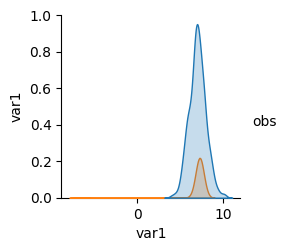

[1760/2000]: loss_d: 0.084, loss_g: -0.384
[1770/2000]: loss_d: 0.086, loss_g: -0.391
[1780/2000]: loss_d: 0.076, loss_g: -0.394
[1790/2000]: loss_d: 0.076, loss_g: -0.413
[1800/2000]: loss_d: 0.084, loss_g: -0.377


10.0


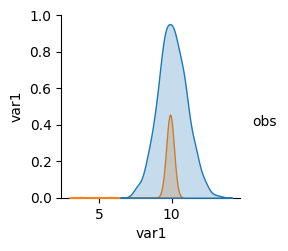

[1810/2000]: loss_d: 0.084, loss_g: -0.386
[1820/2000]: loss_d: 0.107, loss_g: -0.324
[1830/2000]: loss_d: 0.088, loss_g: -0.406
[1840/2000]: loss_d: 0.097, loss_g: -0.350
[1850/2000]: loss_d: 0.090, loss_g: -0.385


15.0


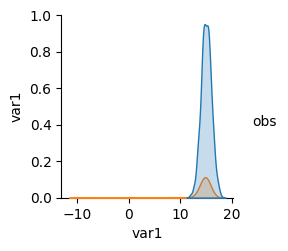

[1860/2000]: loss_d: 0.095, loss_g: -0.396
[1870/2000]: loss_d: 0.101, loss_g: -0.382
[1880/2000]: loss_d: 0.108, loss_g: -0.406
[1890/2000]: loss_d: 0.111, loss_g: -0.405
[1900/2000]: loss_d: 0.088, loss_g: -0.436


2.0


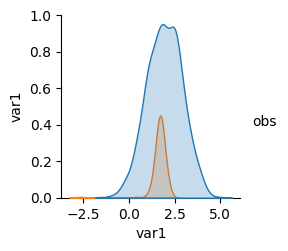

[1910/2000]: loss_d: 0.097, loss_g: -0.378
[1920/2000]: loss_d: 0.096, loss_g: -0.435
[1930/2000]: loss_d: 0.083, loss_g: -0.420
[1940/2000]: loss_d: 0.083, loss_g: -0.406
[1950/2000]: loss_d: 0.086, loss_g: -0.410


9.0


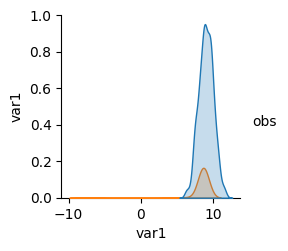

[1960/2000]: loss_d: 0.096, loss_g: -0.379
[1970/2000]: loss_d: 0.100, loss_g: -0.396
[1980/2000]: loss_d: 0.135, loss_g: -0.367
[1990/2000]: loss_d: 0.097, loss_g: -0.463


In [19]:
wgan_1n.train(n_epochs=2000)

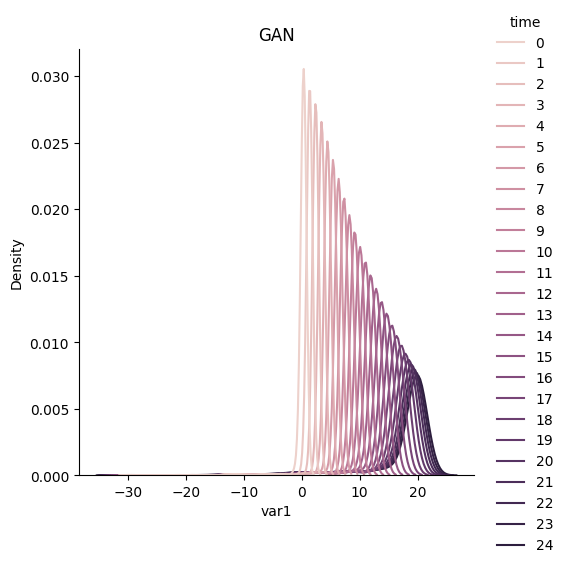

In [20]:

samples = wgan_1n.sample(time_periods=np.arange(0,T+H_STEPS), sample_size=N_SAMPLES)

sns.displot(samples, x='var1', hue='time', kind='kde')
plt.title('GAN')
plt.show()

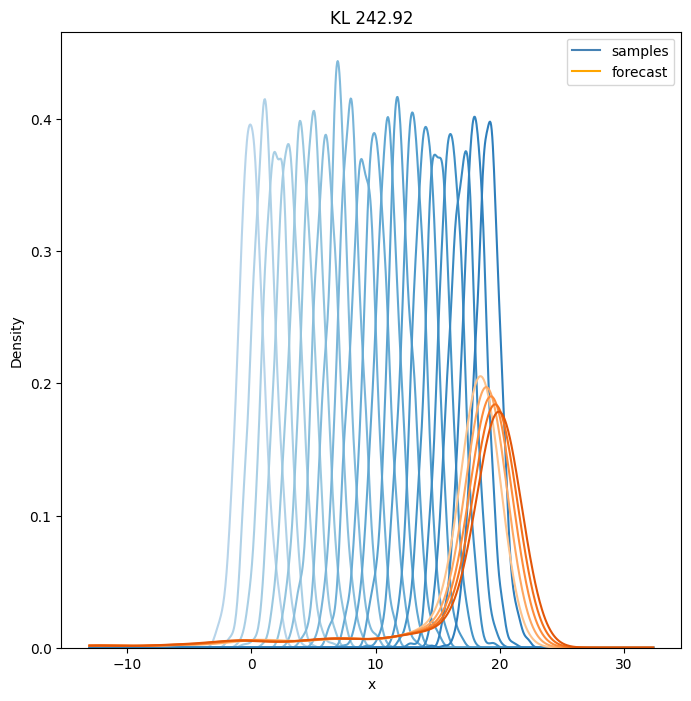

In [21]:
samples = samples[samples.time >= T].reset_index(drop=True)
kde_forecasts = get_kdes(samples, VARS[0], 'time', PREDICT_RANGE)
    
output_wgan = [kde_forecasts[i].score_samples(grid_points.reshape(-1,1)) for i in PREDICT_RANGE]

plt.figure(dpi=100, figsize=(8,8))

kls_w = [get_kl( np.exp(output_wgan[i])[1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_w = np.mean(kls_w)

for n, d in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(n))

for n, o in zip( np.linspace(0.3 ,0.7 , H_STEPS), output_wgan):
  plt.plot(grid_points, np.exp(o), color=ORANGE(n))

plt.title(f'KL {np.round(kl_w, 2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

## 2 Normales (1 dimensión) - Tendencia Lineal

### Datos

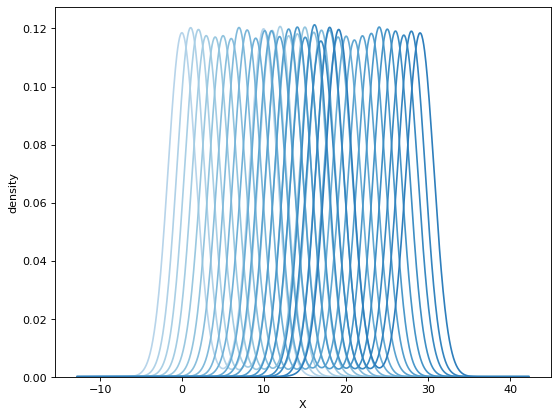

In [22]:
np.random.seed(SEED)

sigma = 1
offset = 10

# Genero observaciones
data = []

for t in TIME_PERIODS:
  samples = np.append(
      np.random.normal(loc=t, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ]),
      np.random.normal(loc=t+10, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ]) # +10
  )
  samples = pd.DataFrame(samples, columns = VARS)
  samples['time'] = t
  data.append(samples)
data = pd.concat(data, ignore_index=True)

# Ajusto KDEs
kdes = get_kdes(data, VARS[0], 'time', TIME_PERIODS)

grid_points = np.linspace(data.var1.min()-offset, data.var1.max()+offset, 1000)
data_matrix = [ kdes[t].score_samples(grid_points.reshape(-1,1)) for t in TIME_PERIODS ]

plt.figure(figsize=(8, 6), dpi=80)

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')

plt.show()

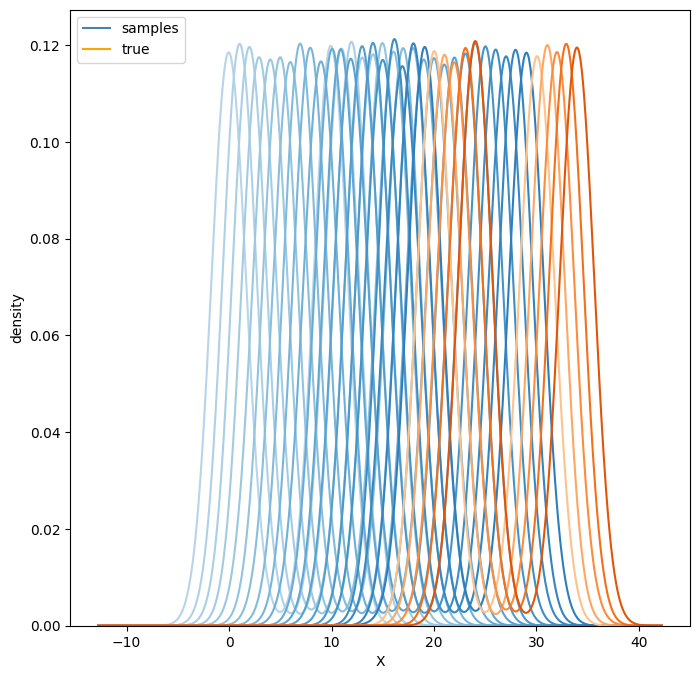

In [23]:
true = []

for t in PREDICT_RANGE:
  samples = np.append(
      np.random.normal(loc=t, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ]),
      np.random.normal(loc=t+10, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ]) # +10
  )
  samples = pd.DataFrame(samples, columns=VARS)
  samples['time'] = t
  true.append(samples)

true = pd.concat(true, ignore_index=True)

true_kdes = get_kdes(true, VARS[0], 'time', PREDICT_RANGE)

true_data_matrix = [true_kdes[t].score_samples(grid_points.reshape(-1,1)) for t in PREDICT_RANGE]

plt.figure(figsize=(8, 8), dpi=100)

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

for i, d in zip(np.linspace(0.3,0.7, H_STEPS), true_data_matrix):
  plt.plot(grid_points, np.exp(d), color=ORANGE(i))

plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='true')
plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')
plt.legend()
plt.show()

### Paramétrico

In [24]:
mixtures = Mixtures(data, VARS, 2)
mixtures.fit()
mixtures.forecast(steps=H_STEPS, predict=['mean'])

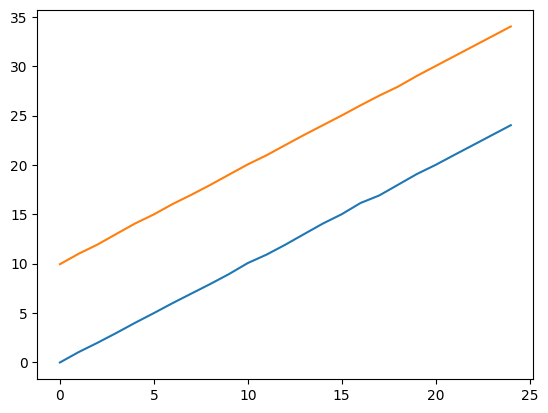

In [25]:
plt.plot(pd.concat([mixtures.medias, mixtures.pred_mean], ignore_index=True))
plt.show()

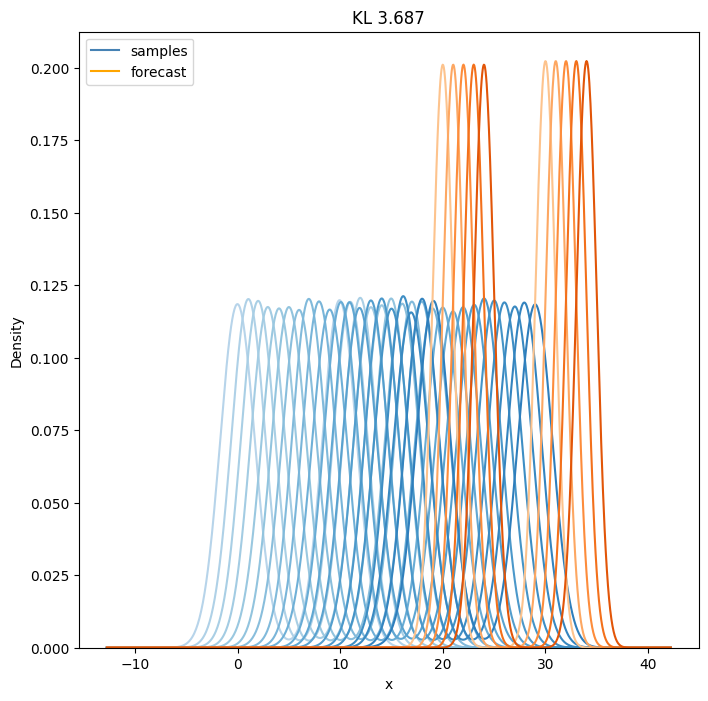

In [26]:
plt.figure(dpi=100, figsize=(8,8))

for i, p in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(p), color=BLUE(i))

preds = [np.exp(m.log_probability(grid_points)) for m in mixtures.new_mixtures]
for i, p in zip(np.linspace(0.3,0.7, H_STEPS), preds):
  plt.plot(grid_points, p, color=ORANGE(i))


kls_p = [get_kl( preds[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_p = np.mean(kls_p)

plt.title(f'KL {np.round(kl_p,2)}')

plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.ylabel('Density')
plt.xlabel('x')
plt.gca().set_ylim(bottom=0)
plt.legend()
plt.show()

### FPCA

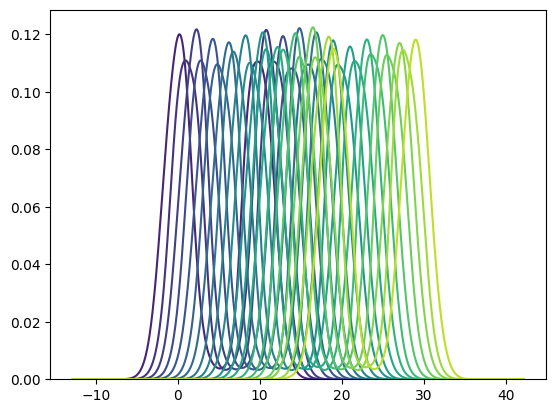

In [27]:
fpca_2n = Fpca(data_matrix, grid_points, n_basis=30)

for n, i in zip(np.linspace(0.1,0.9,T), TIME_PERIODS):
  plt.plot(grid_points, np.exp(fpca_2n.fd[i](grid_points).reshape(-1)), color=VIRIDIS(n))
plt.gca().set_ylim(bottom=0)
plt.show()

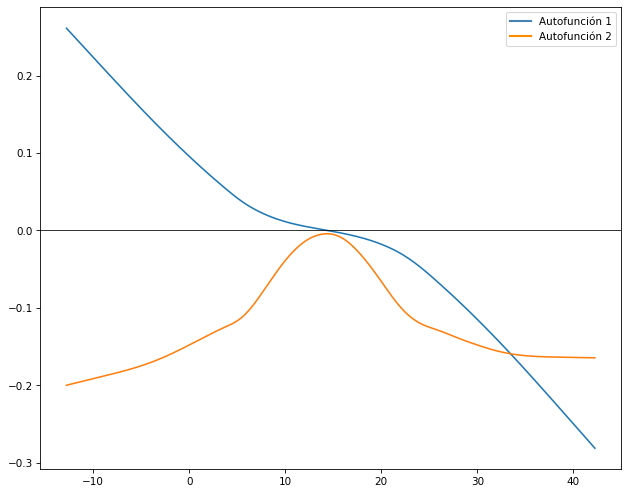

In [28]:
fpca_2n.fit_fpca(2)

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2)]

ax = plt.figure(dpi=75, figsize=(10,8))
fpca_2n.fpca.components_.plot(ax)
plt.axhline(0, color='black', linewidth=0.75)
plt.legend(custom_lines, ['Autofunción 1', 'Autofunción 2'])
plt.show()

In [29]:
print(fpca_2n.fpca.explained_variance_ratio_)
print(fpca_2n.fpca.explained_variance_ratio_.sum())

[0.9559654  0.04311488]
0.9990802776187273


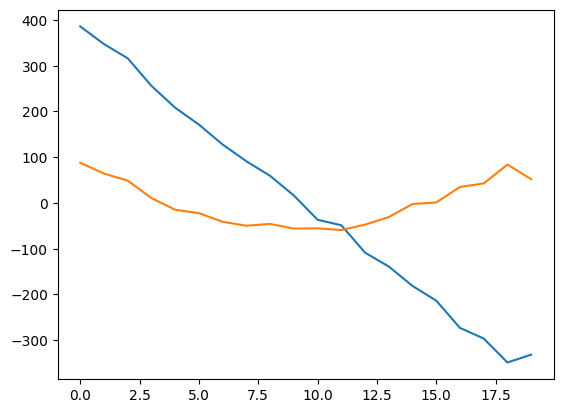

In [30]:
plt.plot(fpca_2n.scores)
plt.show()

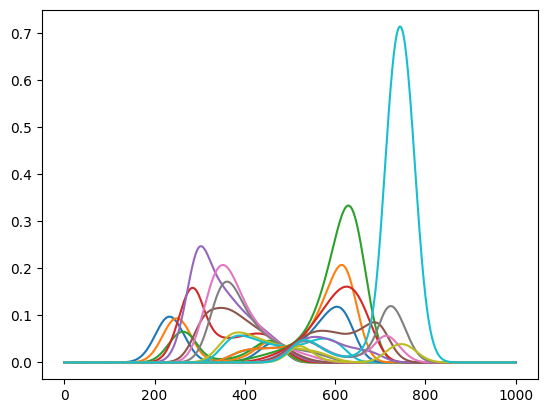

In [31]:
for i in TIME_PERIODS:
  plt.plot(np.exp(fpca_2n.results[i]))
plt.show()

In [32]:
fpca_2n.fit_time_series(h_steps=H_STEPS)

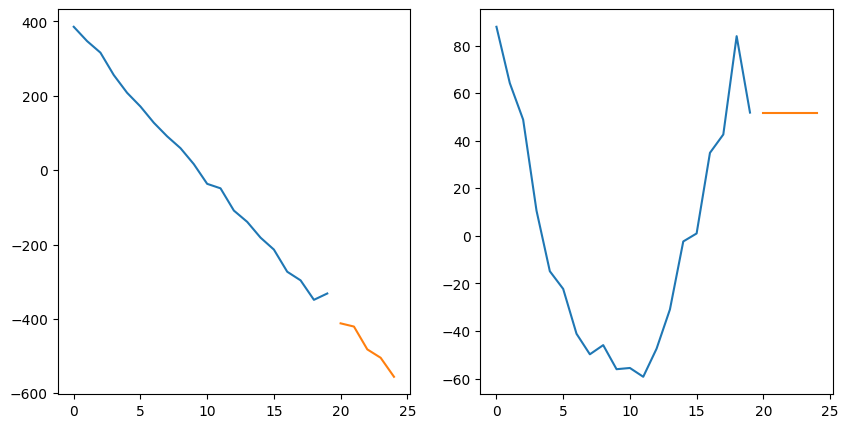

In [33]:
plt.figure(dpi=100, figsize=(10,5))

n_cols = int(np.ceil(np.sqrt(fpca_2n.n_components)))
n_rows = int(np.ceil(fpca_2n.n_components / n_cols))

for i in range(fpca_2n.n_components):
  plt.subplot(n_rows,n_cols,i+1)
  plt.plot(fpca_2n.scores[:,i])
  pred_plot = pd.DataFrame(fpca_2n.pred_w[:,i], index=np.arange(H_STEPS) + T)
  plt.plot(pred_plot)

plt.show()

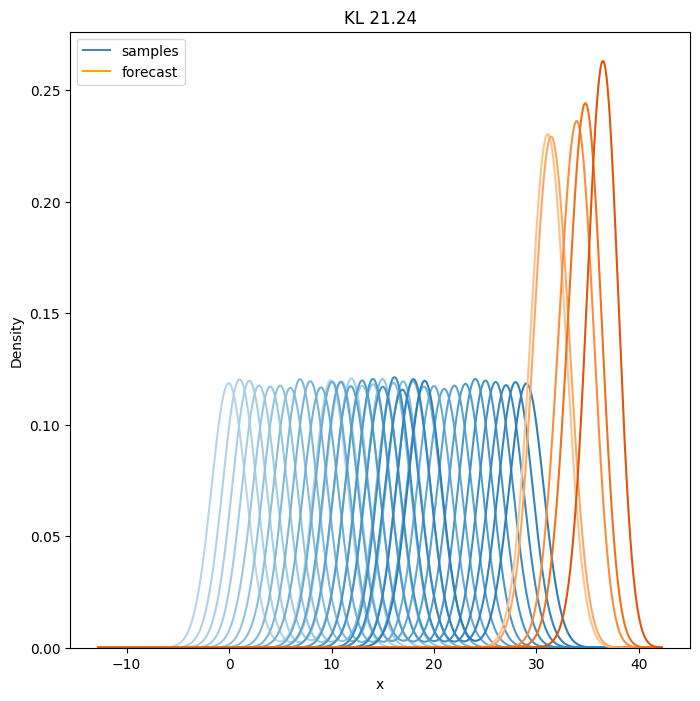

In [34]:
fpca_2n.predict(exp=True, normalize=True)

plt.figure(dpi=100, figsize=(8,8))

for n, i in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(i), color=BLUE(n))

for n, i in zip( np.linspace(0.3 ,0.7 , H_STEPS), fpca_2n.pred_f):
  plt.plot(grid_points, i, color=ORANGE(n))

kls_f = [get_kl( fpca_2n.pred_f[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_f = np.mean(kls_f)
plt.title(f'KL {np.round(kl_f, 2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

### WGAN

In [35]:
np.random.seed(SEED)
torch.manual_seed(SEED)

wgan_2n = Wgan(data = data,
               vars = VARS,
               latent_dim = LATENT_DIM,
               condition_dim = CONDITION_DIM,
               g_hidden_layers = G_HIDDEN_LAYERS,
               g_hidden_dim = G_HIDDEN_DIM,
               g_leaky_relu = G_LEAKY_RELU,
               d_hidden_layers = D_HIDDEN_LAYERS,
               d_hidden_dim = D_HIDDEN_DIM,
               d_dropout = D_DROPOUT,
               d_leaky_relu = D_LEAKY_RELU,
               input_dim = INPUT_DIM,
               lr_gen = LR_GEN,
               lr_dis = LR_DIS,
               b1 = B1,
               b2 = B2,
               lambda_gp = LAMBDA_GP,
               n_critic = N_CRITIC,
               batch_size = BATCH_SIZE,
               device = DEVICE)

[0/2000]: loss_d: 0.371, loss_g: -0.451


15.0


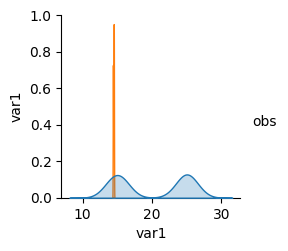

[10/2000]: loss_d: -0.114, loss_g: -0.101
[20/2000]: loss_d: 0.471, loss_g: -0.566
[30/2000]: loss_d: 0.236, loss_g: -0.400
[40/2000]: loss_d: 0.071, loss_g: -0.361
[50/2000]: loss_d: 0.048, loss_g: -0.425


11.0


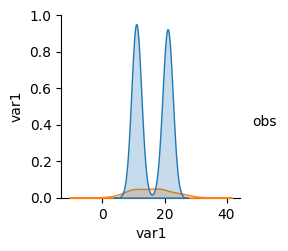

[60/2000]: loss_d: 0.062, loss_g: -0.409
[70/2000]: loss_d: 0.128, loss_g: -0.428
[80/2000]: loss_d: 0.290, loss_g: -0.509
[90/2000]: loss_d: 0.238, loss_g: -0.532
[100/2000]: loss_d: 0.223, loss_g: -0.482


11.0


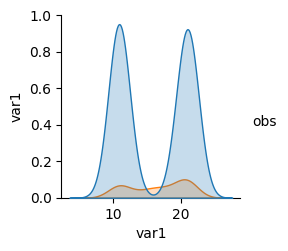

[110/2000]: loss_d: 0.221, loss_g: -0.490
[120/2000]: loss_d: 0.212, loss_g: -0.480
[130/2000]: loss_d: 0.221, loss_g: -0.479
[140/2000]: loss_d: 0.213, loss_g: -0.480
[150/2000]: loss_d: 0.204, loss_g: -0.555


6.0


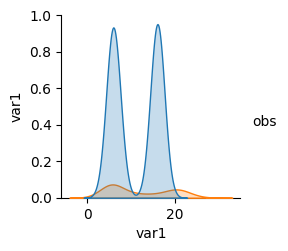

[160/2000]: loss_d: 0.175, loss_g: -0.510
[170/2000]: loss_d: 0.166, loss_g: -0.538
[180/2000]: loss_d: 0.166, loss_g: -0.505
[190/2000]: loss_d: 0.164, loss_g: -0.537
[200/2000]: loss_d: 0.166, loss_g: -0.545


1.0


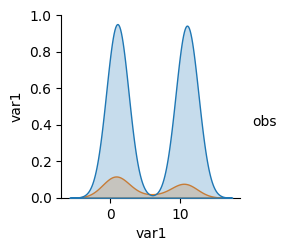

[210/2000]: loss_d: 0.168, loss_g: -0.531
[220/2000]: loss_d: 0.172, loss_g: -0.532
[230/2000]: loss_d: 0.167, loss_g: -0.508
[240/2000]: loss_d: 0.167, loss_g: -0.518
[250/2000]: loss_d: 0.167, loss_g: -0.528


19.0


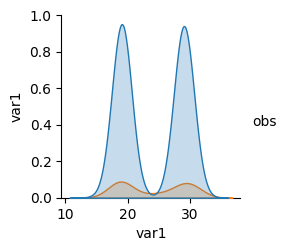

[260/2000]: loss_d: 0.161, loss_g: -0.544
[270/2000]: loss_d: 0.157, loss_g: -0.533
[280/2000]: loss_d: 0.154, loss_g: -0.512
[290/2000]: loss_d: 0.169, loss_g: -0.469
[300/2000]: loss_d: 0.157, loss_g: -0.513


15.0


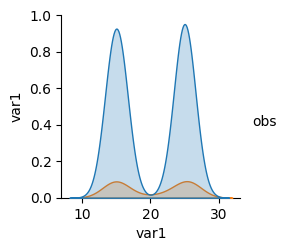

[310/2000]: loss_d: 0.152, loss_g: -0.532
[320/2000]: loss_d: 0.162, loss_g: -0.506
[330/2000]: loss_d: 0.150, loss_g: -0.535
[340/2000]: loss_d: 0.158, loss_g: -0.501
[350/2000]: loss_d: 0.149, loss_g: -0.551


11.0


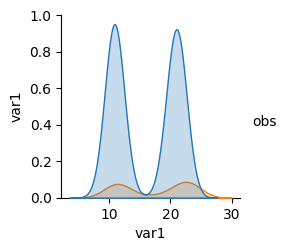

[360/2000]: loss_d: 0.143, loss_g: -0.537
[370/2000]: loss_d: 0.145, loss_g: -0.541
[380/2000]: loss_d: 0.144, loss_g: -0.548
[390/2000]: loss_d: 0.136, loss_g: -0.554
[400/2000]: loss_d: 0.124, loss_g: -0.550


0.0


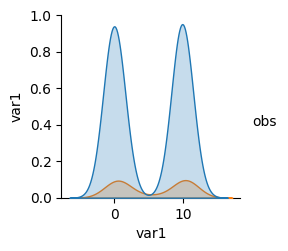

[410/2000]: loss_d: 0.122, loss_g: -0.550
[420/2000]: loss_d: 0.119, loss_g: -0.537
[430/2000]: loss_d: 0.128, loss_g: -0.544
[440/2000]: loss_d: 0.124, loss_g: -0.542
[450/2000]: loss_d: 0.135, loss_g: -0.546


17.0


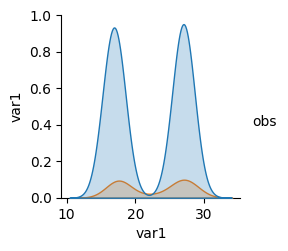

[460/2000]: loss_d: 0.126, loss_g: -0.512
[470/2000]: loss_d: 0.133, loss_g: -0.516
[480/2000]: loss_d: 0.123, loss_g: -0.527
[490/2000]: loss_d: 0.117, loss_g: -0.538
[500/2000]: loss_d: 0.112, loss_g: -0.523


7.0


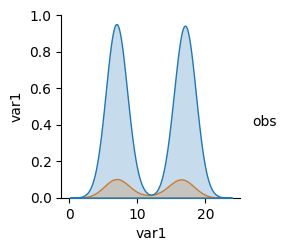

[510/2000]: loss_d: 0.104, loss_g: -0.512
[520/2000]: loss_d: 0.112, loss_g: -0.518
[530/2000]: loss_d: 0.106, loss_g: -0.524
[540/2000]: loss_d: 0.112, loss_g: -0.519
[550/2000]: loss_d: 0.118, loss_g: -0.510


9.0


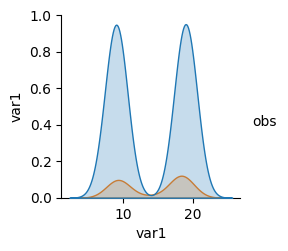

[560/2000]: loss_d: 0.114, loss_g: -0.511
[570/2000]: loss_d: 0.115, loss_g: -0.506
[580/2000]: loss_d: 0.113, loss_g: -0.522
[590/2000]: loss_d: 0.110, loss_g: -0.521
[600/2000]: loss_d: 0.110, loss_g: -0.522


5.0


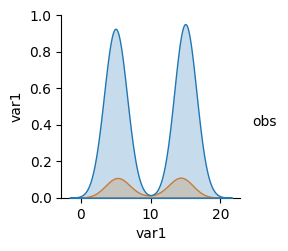

[610/2000]: loss_d: 0.110, loss_g: -0.513
[620/2000]: loss_d: 0.102, loss_g: -0.518
[630/2000]: loss_d: 0.110, loss_g: -0.508
[640/2000]: loss_d: 0.107, loss_g: -0.522
[650/2000]: loss_d: 0.109, loss_g: -0.518


18.0


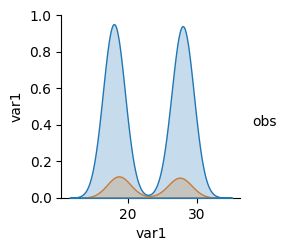

[660/2000]: loss_d: 0.105, loss_g: -0.513
[670/2000]: loss_d: 0.124, loss_g: -0.487
[680/2000]: loss_d: 0.161, loss_g: -0.393
[690/2000]: loss_d: 0.149, loss_g: -0.406
[700/2000]: loss_d: 0.143, loss_g: -0.400


1.0


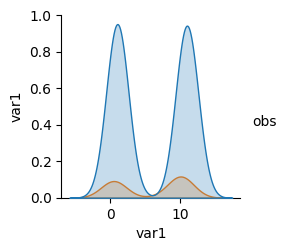

[710/2000]: loss_d: 0.138, loss_g: -0.441
[720/2000]: loss_d: 0.128, loss_g: -0.473
[730/2000]: loss_d: 0.137, loss_g: -0.495
[740/2000]: loss_d: 0.131, loss_g: -0.499
[750/2000]: loss_d: 0.136, loss_g: -0.481


10.0


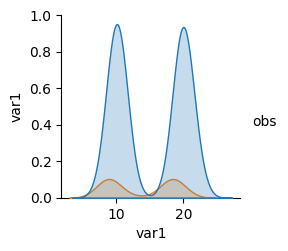

[760/2000]: loss_d: 0.133, loss_g: -0.495
[770/2000]: loss_d: 0.123, loss_g: -0.483
[780/2000]: loss_d: 0.119, loss_g: -0.477
[790/2000]: loss_d: 0.117, loss_g: -0.489
[800/2000]: loss_d: 0.115, loss_g: -0.479


4.0


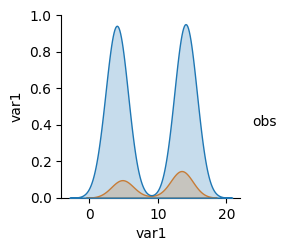

[810/2000]: loss_d: 0.115, loss_g: -0.477
[820/2000]: loss_d: 0.118, loss_g: -0.486
[830/2000]: loss_d: 0.110, loss_g: -0.474
[840/2000]: loss_d: 0.112, loss_g: -0.481
[850/2000]: loss_d: 0.108, loss_g: -0.477


8.0


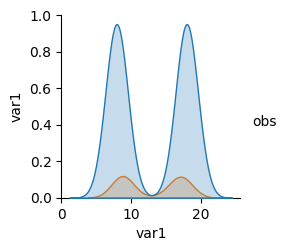

[860/2000]: loss_d: 0.109, loss_g: -0.477
[870/2000]: loss_d: 0.113, loss_g: -0.485
[880/2000]: loss_d: 0.111, loss_g: -0.485
[890/2000]: loss_d: 0.110, loss_g: -0.478
[900/2000]: loss_d: 0.111, loss_g: -0.494


5.0


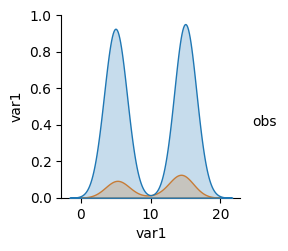

[910/2000]: loss_d: 0.107, loss_g: -0.493
[920/2000]: loss_d: 0.110, loss_g: -0.498
[930/2000]: loss_d: 0.111, loss_g: -0.505
[940/2000]: loss_d: 0.115, loss_g: -0.495
[950/2000]: loss_d: 0.211, loss_g: -0.332


17.0


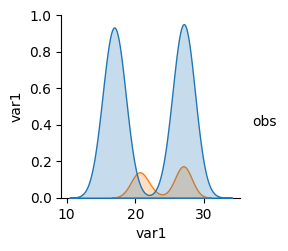

[960/2000]: loss_d: 0.333, loss_g: -0.363
[970/2000]: loss_d: -0.037, loss_g: -0.386
[980/2000]: loss_d: 0.358, loss_g: -0.567
[990/2000]: loss_d: -0.061, loss_g: -0.382
[1000/2000]: loss_d: 0.222, loss_g: -0.284


12.0


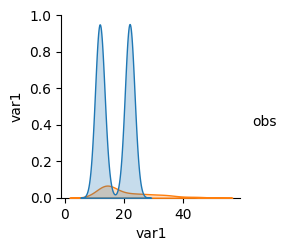

[1010/2000]: loss_d: 0.158, loss_g: -0.430
[1020/2000]: loss_d: 0.129, loss_g: -0.491
[1030/2000]: loss_d: 0.133, loss_g: -0.493
[1040/2000]: loss_d: 0.122, loss_g: -0.490
[1050/2000]: loss_d: 0.131, loss_g: -0.494


10.0


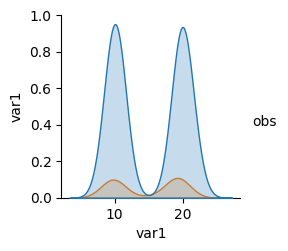

[1060/2000]: loss_d: 0.129, loss_g: -0.481
[1070/2000]: loss_d: 0.129, loss_g: -0.494
[1080/2000]: loss_d: 0.140, loss_g: -0.493
[1090/2000]: loss_d: 0.146, loss_g: -0.497
[1100/2000]: loss_d: 0.149, loss_g: -0.492


18.0


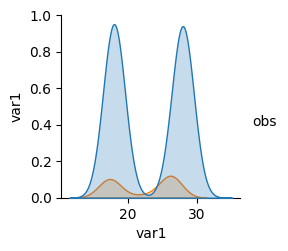

[1110/2000]: loss_d: 0.139, loss_g: -0.491
[1120/2000]: loss_d: 0.140, loss_g: -0.484
[1130/2000]: loss_d: 0.142, loss_g: -0.484
[1140/2000]: loss_d: 0.146, loss_g: -0.479
[1150/2000]: loss_d: 0.164, loss_g: -0.418


15.0


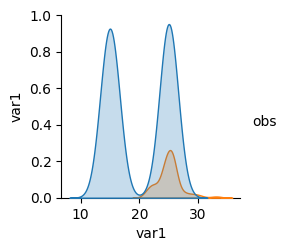

[1160/2000]: loss_d: 0.326, loss_g: -0.356
[1170/2000]: loss_d: 0.327, loss_g: -0.412
[1180/2000]: loss_d: 0.008, loss_g: -0.405
[1190/2000]: loss_d: 0.038, loss_g: -0.397
[1200/2000]: loss_d: 0.242, loss_g: -0.388


19.0


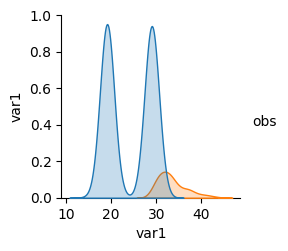

[1210/2000]: loss_d: -0.106, loss_g: -0.374
[1220/2000]: loss_d: 0.367, loss_g: -0.791
[1230/2000]: loss_d: -0.072, loss_g: -0.386
[1240/2000]: loss_d: 0.132, loss_g: -0.489
[1250/2000]: loss_d: 0.133, loss_g: -0.459


2.0


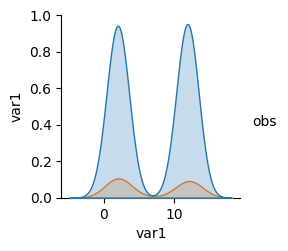

[1260/2000]: loss_d: 0.142, loss_g: -0.475
[1270/2000]: loss_d: 0.142, loss_g: -0.478
[1280/2000]: loss_d: 0.146, loss_g: -0.478
[1290/2000]: loss_d: 0.129, loss_g: -0.484
[1300/2000]: loss_d: 0.137, loss_g: -0.490


2.0


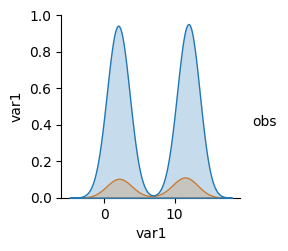

[1310/2000]: loss_d: 0.130, loss_g: -0.470
[1320/2000]: loss_d: 0.133, loss_g: -0.467
[1330/2000]: loss_d: 0.134, loss_g: -0.489
[1340/2000]: loss_d: 0.130, loss_g: -0.475
[1350/2000]: loss_d: 0.130, loss_g: -0.482


0.0


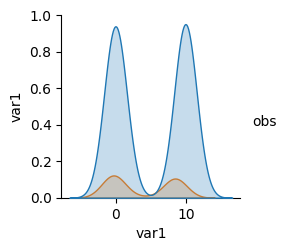

[1360/2000]: loss_d: 0.141, loss_g: -0.430
[1370/2000]: loss_d: 0.063, loss_g: -0.426
[1380/2000]: loss_d: -0.016, loss_g: -0.381
[1390/2000]: loss_d: 0.222, loss_g: -0.327
[1400/2000]: loss_d: 0.094, loss_g: -0.441


19.0


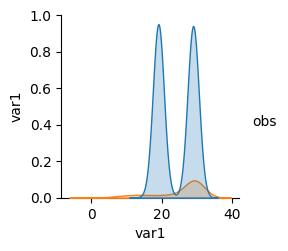

[1410/2000]: loss_d: 0.133, loss_g: -0.505
[1420/2000]: loss_d: 0.151, loss_g: -0.481
[1430/2000]: loss_d: 0.146, loss_g: -0.477
[1440/2000]: loss_d: 0.140, loss_g: -0.479
[1450/2000]: loss_d: 0.140, loss_g: -0.484


3.0


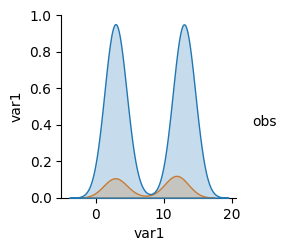

[1460/2000]: loss_d: 0.145, loss_g: -0.481
[1470/2000]: loss_d: 0.144, loss_g: -0.499
[1480/2000]: loss_d: 0.134, loss_g: -0.483
[1490/2000]: loss_d: 0.140, loss_g: -0.469
[1500/2000]: loss_d: 0.140, loss_g: -0.472


9.0


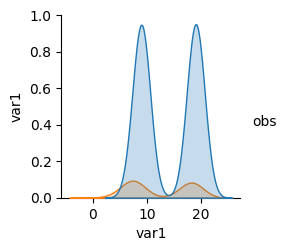

[1510/2000]: loss_d: 0.140, loss_g: -0.479
[1520/2000]: loss_d: 0.143, loss_g: -0.471
[1530/2000]: loss_d: 0.141, loss_g: -0.471
[1540/2000]: loss_d: 0.138, loss_g: -0.468
[1550/2000]: loss_d: 0.149, loss_g: -0.448


11.0


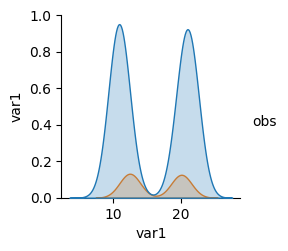

[1560/2000]: loss_d: 0.146, loss_g: -0.450
[1570/2000]: loss_d: 0.147, loss_g: -0.462
[1580/2000]: loss_d: 0.151, loss_g: -0.453
[1590/2000]: loss_d: 0.149, loss_g: -0.453
[1600/2000]: loss_d: 0.153, loss_g: -0.462


1.0


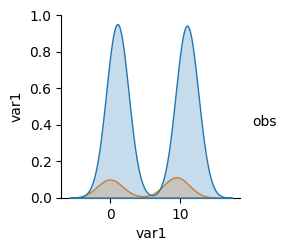

[1610/2000]: loss_d: 0.149, loss_g: -0.444
[1620/2000]: loss_d: 0.154, loss_g: -0.452
[1630/2000]: loss_d: 0.153, loss_g: -0.466
[1640/2000]: loss_d: 0.146, loss_g: -0.457
[1650/2000]: loss_d: 0.153, loss_g: -0.469


8.0


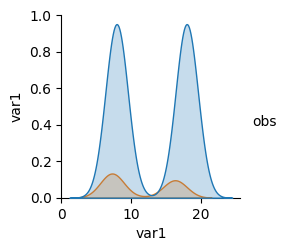

[1660/2000]: loss_d: 0.159, loss_g: -0.471
[1670/2000]: loss_d: 0.153, loss_g: -0.450
[1680/2000]: loss_d: 0.146, loss_g: -0.471
[1690/2000]: loss_d: 0.156, loss_g: -0.483
[1700/2000]: loss_d: 0.147, loss_g: -0.454


19.0


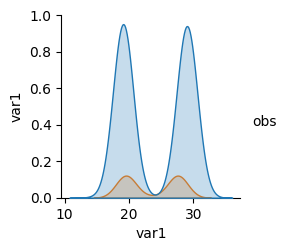

[1710/2000]: loss_d: 0.156, loss_g: -0.466
[1720/2000]: loss_d: 0.157, loss_g: -0.453
[1730/2000]: loss_d: 0.150, loss_g: -0.453
[1740/2000]: loss_d: 0.153, loss_g: -0.468
[1750/2000]: loss_d: 0.153, loss_g: -0.465


7.0


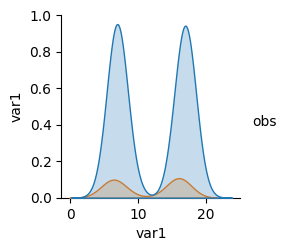

[1760/2000]: loss_d: 0.152, loss_g: -0.453
[1770/2000]: loss_d: 0.154, loss_g: -0.463
[1780/2000]: loss_d: 0.147, loss_g: -0.467
[1790/2000]: loss_d: 0.150, loss_g: -0.477
[1800/2000]: loss_d: 0.155, loss_g: -0.469


10.0


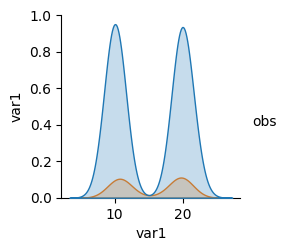

[1810/2000]: loss_d: 0.150, loss_g: -0.462
[1820/2000]: loss_d: 0.148, loss_g: -0.465
[1830/2000]: loss_d: 0.153, loss_g: -0.452
[1840/2000]: loss_d: 0.150, loss_g: -0.456
[1850/2000]: loss_d: 0.142, loss_g: -0.458


15.0


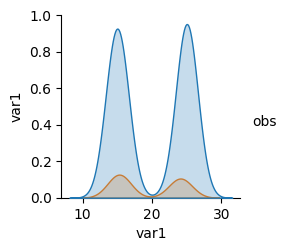

[1860/2000]: loss_d: 0.154, loss_g: -0.457
[1870/2000]: loss_d: 0.147, loss_g: -0.463
[1880/2000]: loss_d: 0.147, loss_g: -0.467
[1890/2000]: loss_d: 0.144, loss_g: -0.460
[1900/2000]: loss_d: 0.148, loss_g: -0.470


2.0


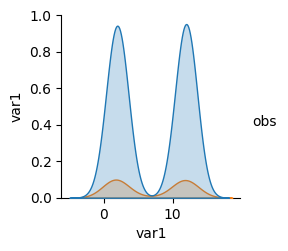

[1910/2000]: loss_d: 0.143, loss_g: -0.463
[1920/2000]: loss_d: 0.147, loss_g: -0.449
[1930/2000]: loss_d: 0.143, loss_g: -0.470
[1940/2000]: loss_d: 0.146, loss_g: -0.454
[1950/2000]: loss_d: 0.150, loss_g: -0.452


9.0


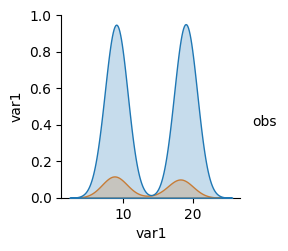

[1960/2000]: loss_d: 0.150, loss_g: -0.461
[1970/2000]: loss_d: 0.146, loss_g: -0.467
[1980/2000]: loss_d: 0.148, loss_g: -0.465
[1990/2000]: loss_d: 0.141, loss_g: -0.470


In [36]:
wgan_2n.train(n_epochs=2000)

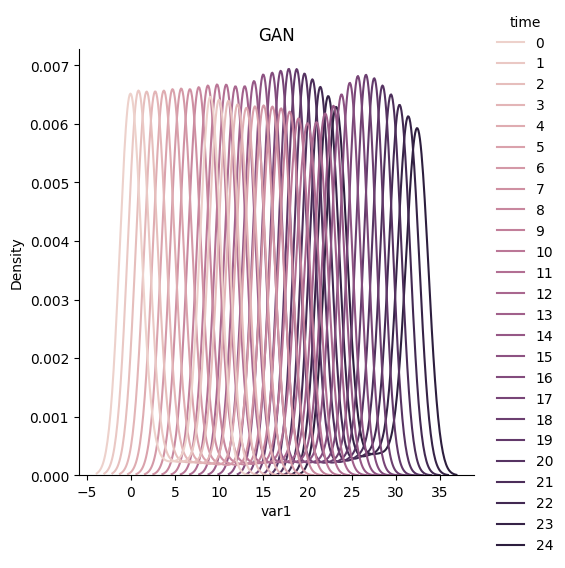

In [37]:
samples = wgan_2n.sample(time_periods=np.arange(0,T+H_STEPS), sample_size=N_SAMPLES)

sns.displot(samples, x='var1', hue='time', kind='kde')
plt.title('GAN')
plt.show()

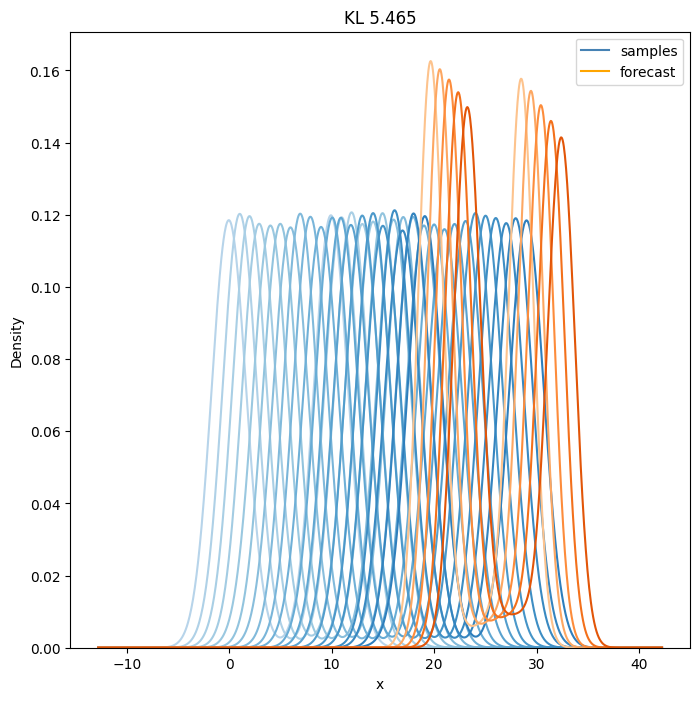

In [38]:
samples = samples[samples.time >= T].reset_index(drop=True)
kde_forecasts = get_kdes(samples, VARS[0], 'time', PREDICT_RANGE)
    
output_wgan = [kde_forecasts[i].score_samples(grid_points.reshape(-1,1)) for i in PREDICT_RANGE]

plt.figure(dpi=100, figsize=(8,8))

kls_w = [get_kl( np.exp(output_wgan[i])[1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_w = np.mean(kls_w)

for n, d in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(n))

for n, o in zip( np.linspace(0.3 ,0.7 , H_STEPS), output_wgan):
  plt.plot(grid_points, np.exp(o), color=ORANGE(n))

plt.title(f'KL {np.round(kl_w, 2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

## Cruce

### Datos

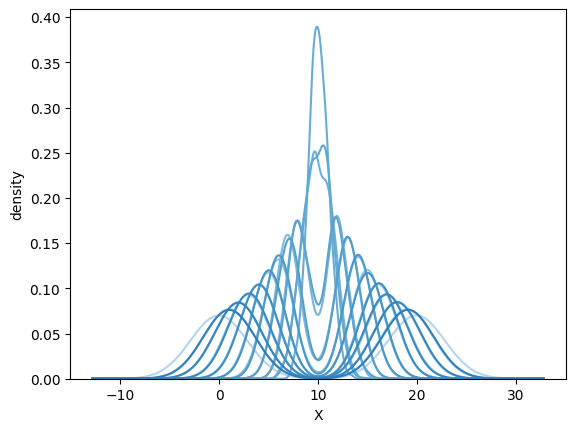

In [39]:
np.random.seed(SEED)

sigma = 1
offset = 10

# Genero observaciones
data = []

for t in TIME_PERIODS:
  samples = np.append(
      np.random.normal(loc=t, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ]),
      np.random.normal(loc=T - t, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ])
  )
  samples = pd.DataFrame(samples, columns = VARS)
  samples['time'] = t
  data.append(samples)
data = pd.concat(data, ignore_index=True)

# Ajusto KDEs
kdes = get_kdes(data, VARS[0], 'time', TIME_PERIODS)

grid_points = np.linspace(data.var1.min()-offset, data.var1.max()+offset, 1000)
data_matrix = [ kdes[t].score_samples(grid_points.reshape(-1,1)) for t in TIME_PERIODS ]

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')

plt.show()

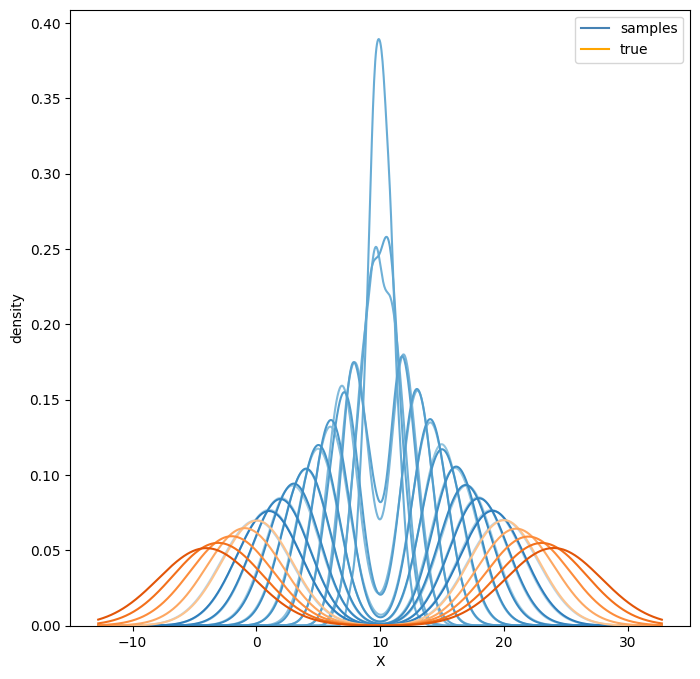

In [40]:
true = []

for t in PREDICT_RANGE:
  samples = np.append(
      np.random.normal(loc=t, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ]),
      np.random.normal(loc=T - t, scale=sigma, size=[ N_SAMPLES//2, len(VARS) ])
  )
  samples = pd.DataFrame(samples, columns=VARS)
  samples['time'] = t
  true.append(samples)

true = pd.concat(true, ignore_index=True)

true_kdes = get_kdes(true, VARS[0], 'time', PREDICT_RANGE)

true_data_matrix = [true_kdes[t].score_samples(grid_points.reshape(-1,1)) for t in PREDICT_RANGE]

plt.figure(figsize=(8, 8), dpi=100)

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

for i, d in zip(np.linspace(0.3,0.7, H_STEPS), true_data_matrix):
  plt.plot(grid_points, np.exp(d), color=ORANGE(i))

plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='true')
plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')
plt.legend()
plt.show()

### Paramétrico

In [41]:
mixtures = Mixtures(data, VARS, 2)
mixtures.fit()
cruce = mixtures.medias[mixtures.medias.m_0.shift(1) > mixtures.medias.m_0].index[0]
mixtures.medias.loc[cruce:, ['m_0', 'm_1']] = mixtures.medias.loc[cruce:, ['m_1', 'm_0']].values
mixtures.desvios.loc[cruce:, ['d_0', 'd_1']] = mixtures.desvios.loc[cruce:, ['d_1', 'd_0']].values
mixtures.weights.loc[cruce:, ['w_0', 'w_1']] = mixtures.weights.loc[cruce:, ['w_1', 'w_0']].values
mixtures.forecast(steps=H_STEPS, predict=['mean'])

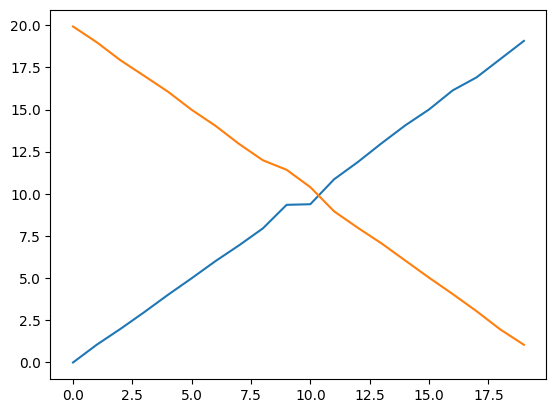

In [42]:
plt.plot(mixtures.medias)
plt.show()

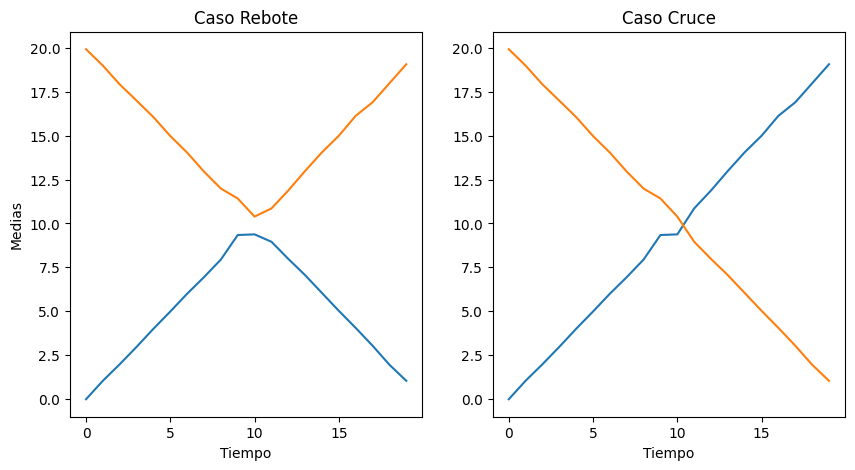

In [43]:
plt.figure(figsize=(10,5), dpi=100)

medias_altn = mixtures.medias.copy()
medias_altn.iloc[11:] = np.flip(mixtures.medias.iloc[11:].values, 1)
plt.subplot(1,2,1)
plt.plot(medias_altn)
plt.title('Caso Rebote')
plt.xlabel('Tiempo')
plt.ylabel('Medias')

plt.subplot(1,2,2)
plt.plot(mixtures.medias)
plt.title('Caso Cruce')
plt.xlabel('Tiempo')
plt.show()

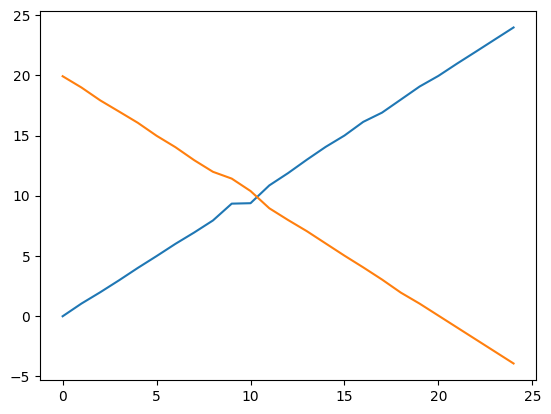

In [44]:
plt.plot( pd.concat([mixtures.medias, mixtures.pred_mean], ignore_index=True) )
plt.show()

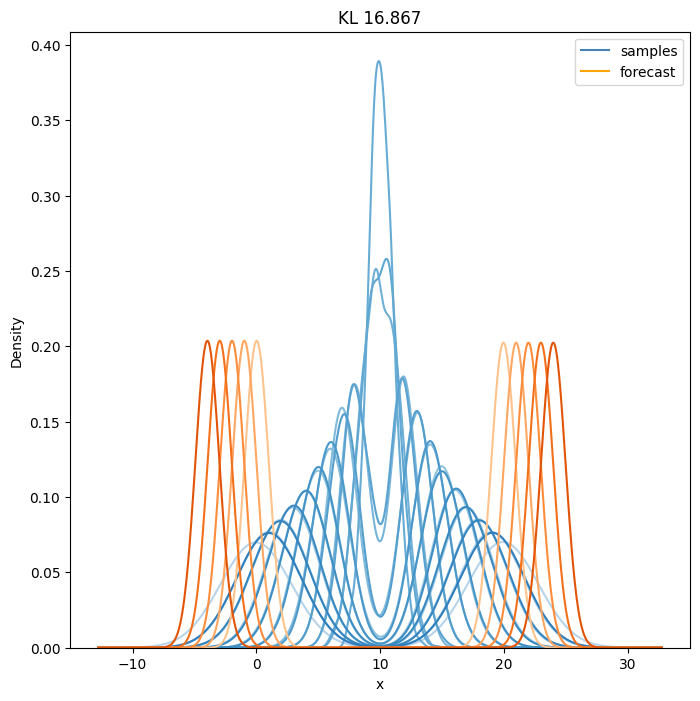

In [45]:
plt.figure(dpi=100, figsize=(8,8))

for i, p in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(p), color=BLUE(i))

preds = [np.exp(m.log_probability(grid_points)) for m in mixtures.new_mixtures]
for i, p in zip(np.linspace(0.3,0.7, H_STEPS), preds):
  plt.plot(grid_points, p, color=ORANGE(i))

kls_p = [get_kl( preds[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_p = np.mean(kls_p)

plt.title(f'KL {np.round(kl_p,2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

### FPCA

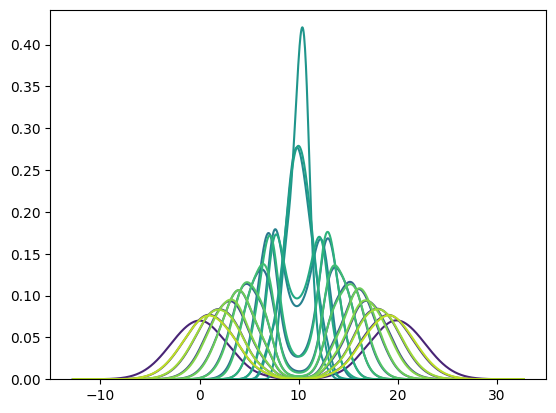

In [46]:
fpca_cruce = Fpca(data_matrix, grid_points, n_basis=30)

for n, i in zip(np.linspace(0.1,0.9,T), TIME_PERIODS):
  plt.plot(grid_points, np.exp(fpca_cruce.fd[i](grid_points).reshape(-1)), color=VIRIDIS(n))
plt.gca().set_ylim(bottom=0)
plt.show()

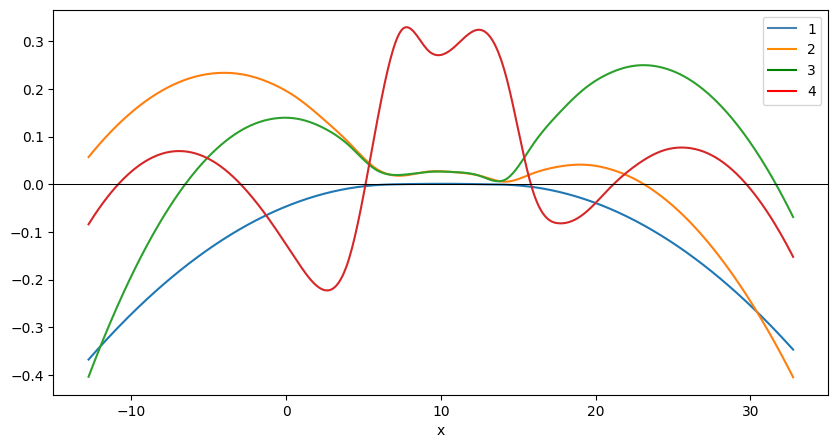

In [47]:
fpca_cruce.fit_fpca(4)

custom_lines = [Line2D([0], [0], color='steelblue', lw=1.5),
                Line2D([0], [0], color='darkorange', lw=1.5),
                Line2D([0], [0], color='green', lw=1.5),
                Line2D([0], [0], color='red', lw=1.5),]
                #Line2D([0], [0], color='purple', lw=1.5)]

ax = plt.figure(dpi=100, figsize=(10,5))
fpca_cruce.fpca.components_.plot(ax)
plt.axhline(0, color='black', linewidth=0.75)
plt.xlabel('x')
plt.legend(custom_lines, [f'{i}' for i in range(1,6)])
plt.show()

In [48]:
print(fpca_cruce.fpca.explained_variance_ratio_)
print(fpca_cruce.fpca.explained_variance_ratio_.sum())

[9.99355994e-01 5.14072371e-04 1.25405809e-04 3.04793004e-06]
0.9999985196211503


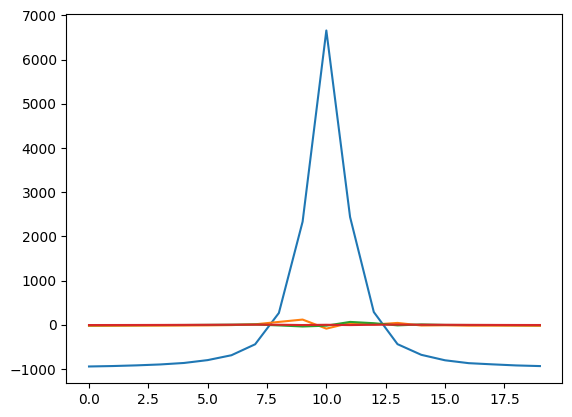

In [49]:
plt.plot(fpca_cruce.scores)
plt.show()

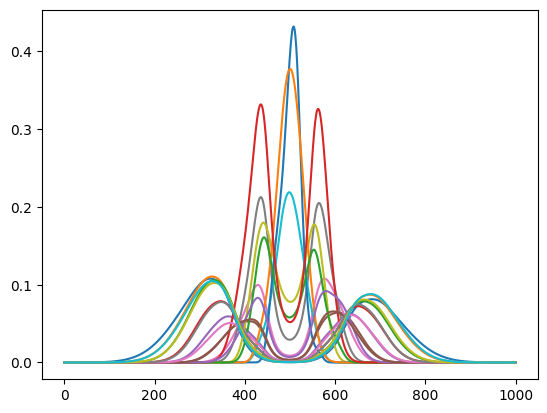

In [50]:
for i in TIME_PERIODS:
  plt.plot(np.exp(fpca_cruce.results[i]))
plt.show()

In [51]:
models = {}

models[0] = FitData('log-lin')
models[0].fit(TIME_PERIODS[11:], fpca_cruce.scores[11:,0])

# Después lo piso

models[1] = FitData('lin')
models[1].fit(TIME_PERIODS, fpca_cruce.scores[:,1])

models[2] = auto_arima(fpca_cruce.scores[:,2], start_p=0, d=1, start_q=0,
                     max_p=10, max_d=10, max_q=10, start_P=0,
                     D=1, start_Q=0, max_P=10, max_D=10,
                     max_Q=10, m=1, seasonal=False,
                     error_action='warn', trace=True,
                     stepwise=True, random_state=20, n_fits=1000 )

models[3] = auto_arima(fpca_cruce.scores[:,3], start_p=0, d=3, start_q=0,
                     max_p=10, max_d=10, max_q=10, start_P=0,
                     D=1, start_Q=0, max_P=10, max_D=10,
                     max_Q=10, m=1, seasonal=False,
                     error_action='warn', trace=True,
                     stepwise=True, random_state=20, n_fits=1000 )

fpca_cruce.fit_time_series(models=models, h_steps=H_STEPS)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=181.150, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=183.082, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=179.150, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.079 seconds
Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=130.655, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=117.854, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=111.450, Time=0.01 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=112.458, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,3,0)(0,

In [52]:
fpca_cruce.pred_w[:,1] = [fpca_cruce.scores[-1,1]]*H_STEPS # dejamos este score constante

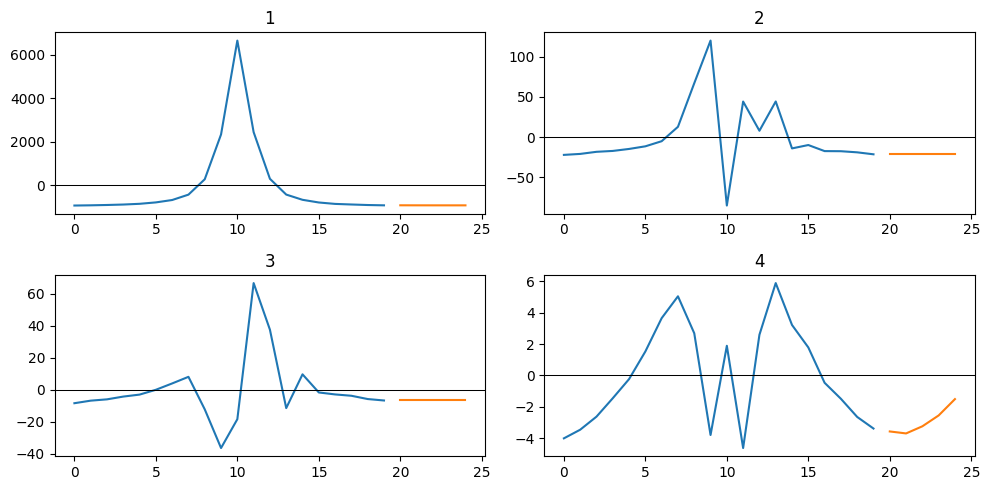

In [53]:
plt.figure(dpi=100, figsize=(10,5))

n_cols = int(np.ceil(np.sqrt(fpca_cruce.n_components)))
n_rows = int(np.ceil(fpca_cruce.n_components / n_cols))

for i in range(fpca_cruce.n_components):
  plt.subplot(n_rows,n_cols,i+1)
  plt.plot(fpca_cruce.scores[:,i])
  pred_plot = pd.DataFrame(fpca_cruce.pred_w[:,i], index=np.arange(H_STEPS) + len(fpca_cruce.scores))
  plt.plot(pred_plot)
  plt.axhline(0, color='black', linewidth=0.75)
  plt.tight_layout()
  plt.title(i+1)

plt.show()

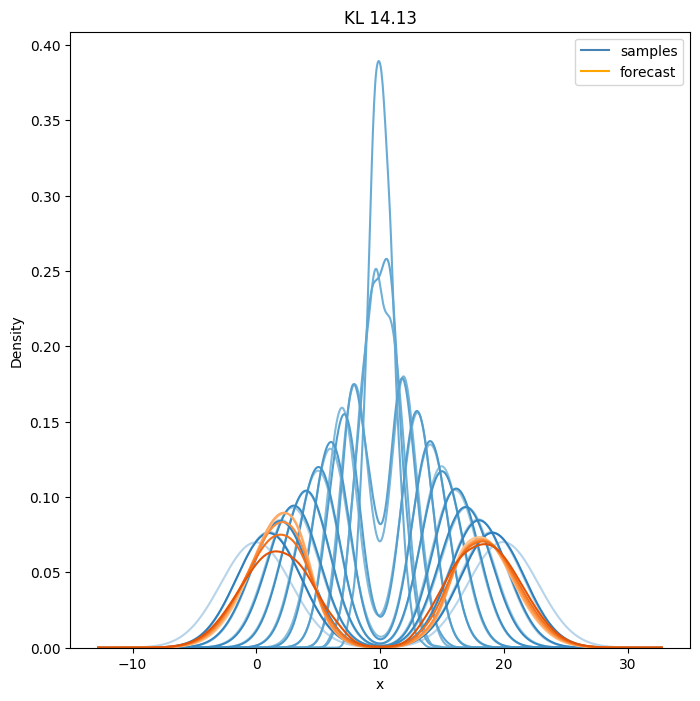

In [54]:
fpca_cruce.predict(exp=True, normalize=True)

plt.figure(dpi=100, figsize=(8,8))

for n, i in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(i), color=BLUE(n))

for n, i in zip( np.linspace(0.3 ,0.7 , H_STEPS), fpca_cruce.pred_f):
  plt.plot(grid_points, i, color=ORANGE(n))

kls_f = [get_kl( fpca_cruce.pred_f[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_f = np.mean(kls_f)
plt.title(f'KL {np.round(kl_f, 2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

### WGAN

In [55]:
np.random.seed(SEED)
torch.manual_seed(SEED)

wgan_cruce = Wgan(data = data,
               vars = VARS,
               latent_dim = LATENT_DIM,
               condition_dim = CONDITION_DIM,
               g_hidden_layers = G_HIDDEN_LAYERS,
               g_hidden_dim = G_HIDDEN_DIM,
               g_leaky_relu = G_LEAKY_RELU,
               d_hidden_layers = D_HIDDEN_LAYERS,
               d_hidden_dim = D_HIDDEN_DIM,
               d_dropout = D_DROPOUT,
               d_leaky_relu = D_LEAKY_RELU,
               input_dim = INPUT_DIM,
               lr_gen = LR_GEN,
               lr_dis = LR_DIS,
               b1 = B1,
               b2 = B2,
               lambda_gp = LAMBDA_GP,
               n_critic = N_CRITIC,
               batch_size = BATCH_SIZE,
               device = DEVICE)

In [ ]:
wgan_cruce.train(n_epochs=2000)

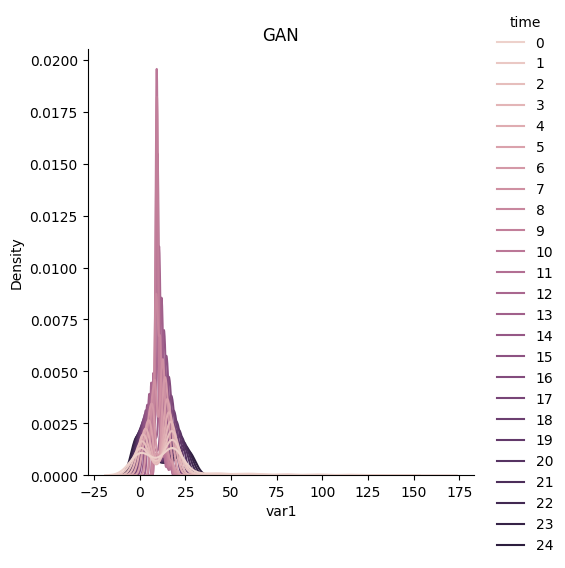

In [57]:
samples = wgan_cruce.sample(time_periods=np.arange(0,T+H_STEPS), sample_size=N_SAMPLES)

sns.displot(samples, x='var1', hue='time', kind='kde')
plt.title('GAN')
plt.show()

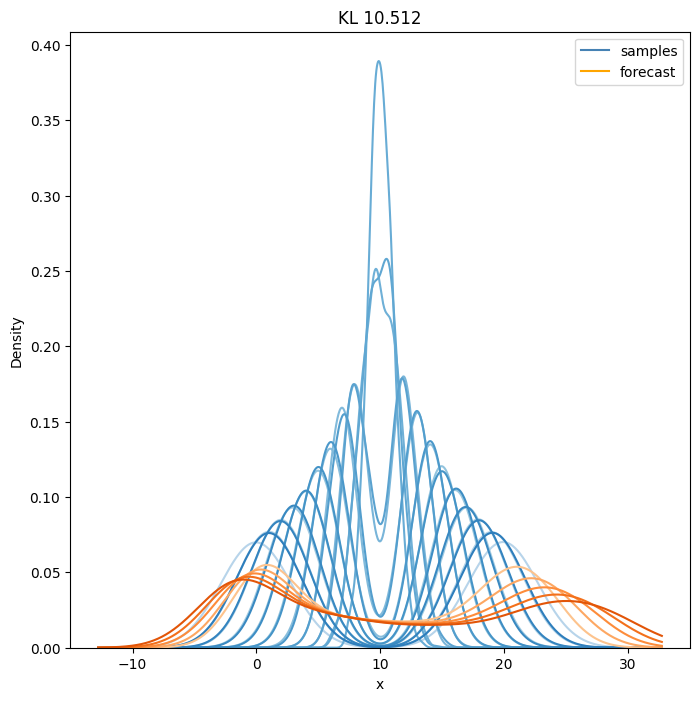

In [58]:
samples = samples[samples.time >= T].reset_index(drop=True)
kde_forecasts = get_kdes(samples, VARS[0], 'time', PREDICT_RANGE)
    
output_wgan = [kde_forecasts[i].score_samples(grid_points.reshape(-1,1)) for i in PREDICT_RANGE]

plt.figure(dpi=100, figsize=(8,8))

kls_w = [get_kl( np.exp(output_wgan[i])[1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_w = np.mean(kls_w)

for n, d in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(n))

for n, o in zip( np.linspace(0.3 ,0.7 , H_STEPS), output_wgan):
  plt.plot(grid_points, np.exp(o), color=ORANGE(n))

plt.title(f'KL {np.round(kl_w, 2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

## Switch

### Datos

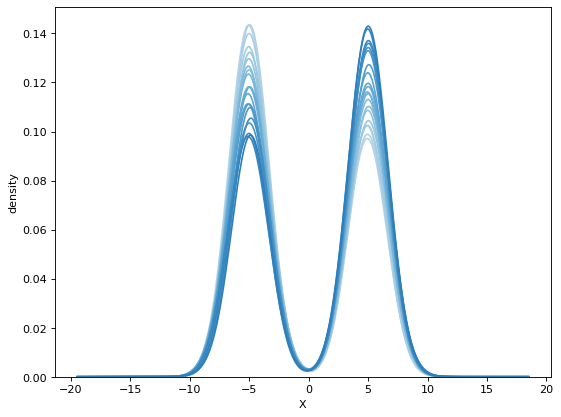

In [59]:
np.random.seed(SEED)

sigma = 1
offset = 10
w1s = np.linspace(0.4, 0.6, len(TIME_PERIODS))

data = []

for t, w1 in zip(TIME_PERIODS, w1s):
  w1 = int(w1 * N_SAMPLES)
  samples = np.append(
      np.random.normal(loc=-5, scale=sigma, size=[ N_SAMPLES-w1, len(VARS) ]),
      np.random.normal(loc=5, scale=sigma, size=[ w1, len(VARS) ])
  )
  samples = pd.DataFrame(samples, columns = VARS)
  samples['time'] = t
  data.append(samples)
data = pd.concat(data, ignore_index=True)

# Ajusto KDEs
kdes = get_kdes(data, VARS[0], 'time', TIME_PERIODS)

grid_points = np.linspace(data.var1.min()-offset, data.var1.max()+offset, 1000)
data_matrix = [ kdes[t].score_samples(grid_points.reshape(-1,1)) for t in TIME_PERIODS ]

plt.figure(figsize=(8, 6), dpi=80)

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')

plt.show()

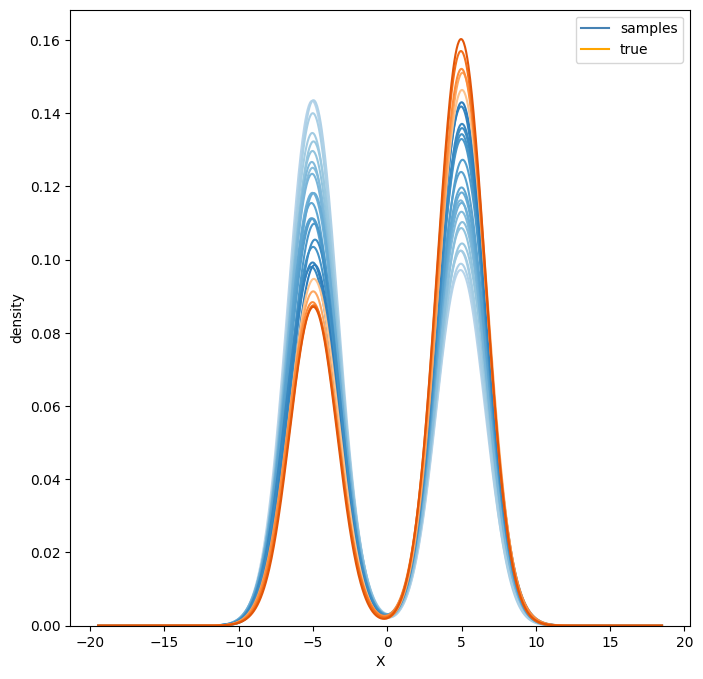

In [60]:
dif = w1s[1] - w1s[0]
pred_w1s = [w1s[-1] + dif*i for i in range(1,H_STEPS+1)]

true = []

for t, w1 in zip(PREDICT_RANGE, pred_w1s):
  w1 = int(w1 * N_SAMPLES)
  samples = np.append(
      np.random.normal(loc=-5, scale=sigma, size=[ N_SAMPLES-w1, len(VARS) ]),
      np.random.normal(loc=5, scale=sigma, size=[ w1, len(VARS) ])
  )
  samples = pd.DataFrame(samples, columns=VARS)
  samples['time'] = t
  true.append(samples)

true = pd.concat(true, ignore_index=True)

true_kdes = get_kdes(true, VARS[0], 'time', PREDICT_RANGE)

true_data_matrix = [true_kdes[t].score_samples(grid_points.reshape(-1,1)) for t in PREDICT_RANGE]

plt.figure(figsize=(8, 8), dpi=100)

for i, d in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

for i, d in zip(np.linspace(0.3,0.7, H_STEPS), true_data_matrix):
  plt.plot(grid_points, np.exp(d), color=ORANGE(i))

plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='true')
plt.gca().set_ylim(bottom=0)
plt.xlabel('X')
plt.ylabel('density')
plt.legend()
plt.show()

### Paramétrico

In [61]:
mixtures = Mixtures(data, VARS, 2)
mixtures.fit()
mixtures.forecast(steps=H_STEPS, predict=['mean','weight'])

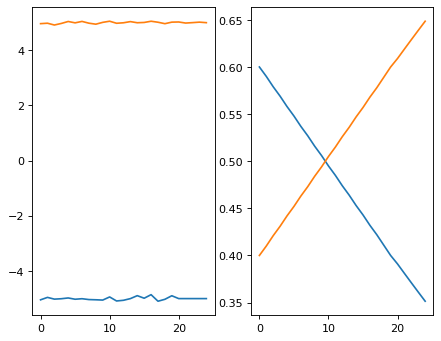

In [62]:
plt.figure(figsize=(10,5), dpi=80)

plt.subplot(1,3,1)
plt.plot(pd.concat([mixtures.medias, mixtures.pred_mean], ignore_index=True))

plt.subplot(1,3,2)
plt.plot(pd.concat([mixtures.weights, mixtures.pred_weight], ignore_index=True))

plt.show()

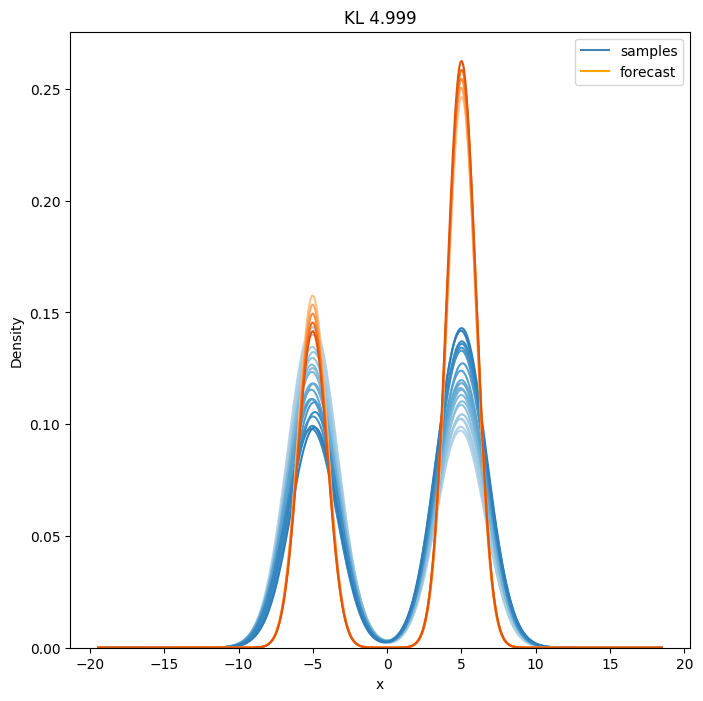

In [63]:
plt.figure(dpi=100, figsize=(8,8))

for i, p in zip(np.linspace(0.3,0.7, T), data_matrix):
  plt.plot(grid_points, np.exp(p), color=BLUE(i))

preds = [np.exp(m.log_probability(grid_points)) for m in mixtures.new_mixtures]
for i, p in zip(np.linspace(0.3,0.7, H_STEPS), preds):
  plt.plot(grid_points, p, color=ORANGE(i))

kls_p = [get_kl( preds[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_p = np.mean(kls_p)

plt.title(f'KL {np.round(kl_p,2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

### FPCA

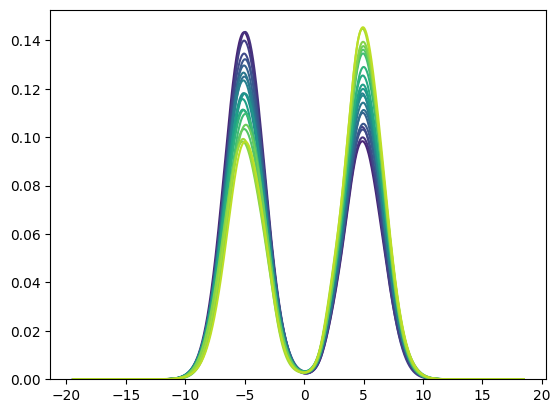

In [64]:
fpca_switch = Fpca(data_matrix, grid_points, n_basis=30)

for n, i in zip(np.linspace(0.1,0.9,T), TIME_PERIODS):
  plt.plot(grid_points, np.exp(fpca_switch.fd[i](grid_points).reshape(-1)), color=VIRIDIS(n))
plt.gca().set_ylim(bottom=0)
plt.show()

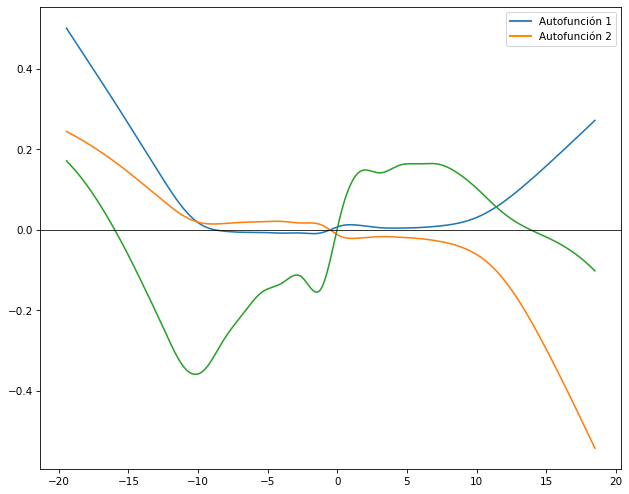

In [65]:
fpca_switch.fit_fpca(3)

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2)]

ax = plt.figure(dpi=75, figsize=(10,8))
fpca_switch.fpca.components_.plot(ax)
plt.axhline(0, color='black', linewidth=0.75)
plt.legend(custom_lines, ['Autofunción 1', 'Autofunción 2'])
plt.show()

In [66]:
print(fpca_switch.fpca.explained_variance_ratio_)
print(fpca_switch.fpca.explained_variance_ratio_.sum())

[0.6593574  0.32156701 0.01264751]
0.9935719266486438


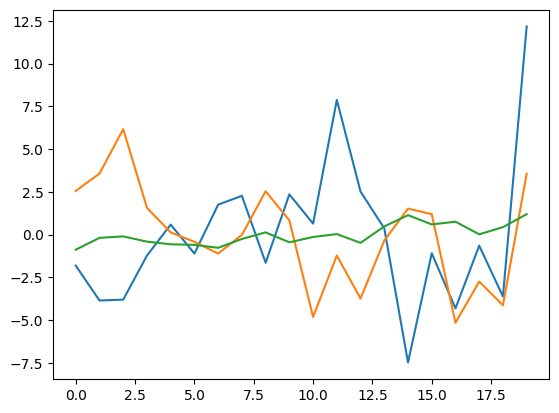

In [67]:
plt.plot(fpca_switch.scores)
plt.show()

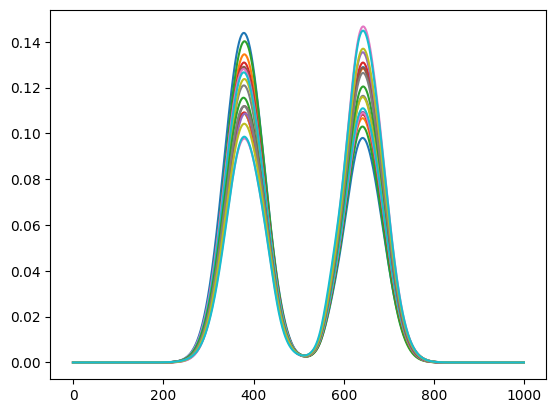

In [68]:
for i in TIME_PERIODS:
  plt.plot(np.exp(fpca_switch.results[i]))
plt.show()

In [69]:
models = {}

models[0] = auto_arima(fpca_switch.scores[:,0], start_p=0, d=2, start_q=0,
                     max_p=10, max_d=10, max_q=10, start_P=0,
                     D=1, start_Q=0, max_P=10, max_D=10,
                     max_Q=10, m=1, seasonal=False,
                     error_action='warn', trace=True,
                     stepwise=True, random_state=20, n_fits=1000 )

models[1] = auto_arima(fpca_switch.scores[:,1], start_p=0, d=1, start_q=0,
                     max_p=10, max_d=10, max_q=10, start_P=0,
                     D=1, start_Q=0, max_P=10, max_D=10,
                     max_Q=10, m=1, seasonal=False,
                     error_action='warn', trace=True,
                     stepwise=True, random_state=20, n_fits=1000 )

models[2] = auto_arima(fpca_switch.scores[:,2], start_p=0, d=1, start_q=0,
                     max_p=10, max_d=10, max_q=10, start_P=0,
                     D=1, start_Q=0, max_P=10, max_D=10,
                     max_Q=10, m=1, seasonal=False,
                     error_action='warn', trace=True,
                     stepwise=True, random_state=20, n_fits=1000 )

fpca_switch.fit_time_series(models=models, h_steps=H_STEPS)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=130.170, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=116.871, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=128.441, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=118.855, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=118.236, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=115.392, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=117.378, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=116.742, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.196 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.099, Time=0.00 sec
 ARIMA(1

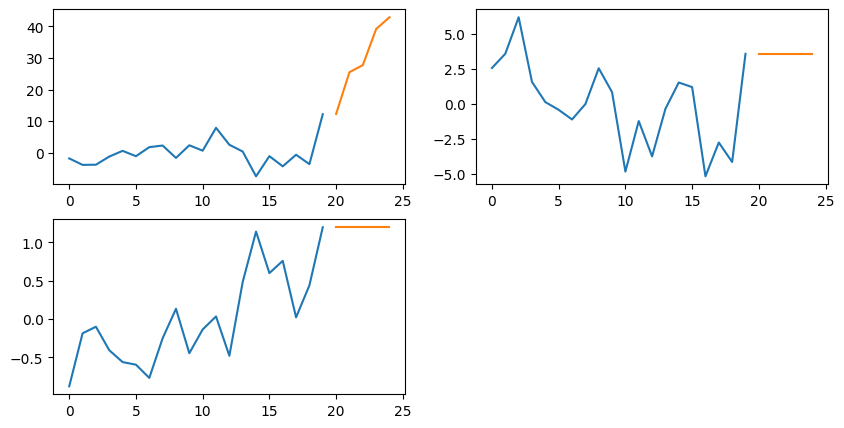

In [70]:
plt.figure(dpi=100, figsize=(10,5))

n_cols = int(np.ceil(np.sqrt(fpca_switch.n_components)))
n_rows = int(np.ceil(fpca_switch.n_components / n_cols))

for i in range(fpca_switch.n_components):
  plt.subplot(n_rows,n_cols,i+1)
  plt.plot(fpca_switch.scores[:,i])
  pred_plot = pd.DataFrame(fpca_switch.pred_w[:,i], index=np.arange(H_STEPS) + len(fpca_switch.scores))
  plt.plot(pred_plot)

plt.show()

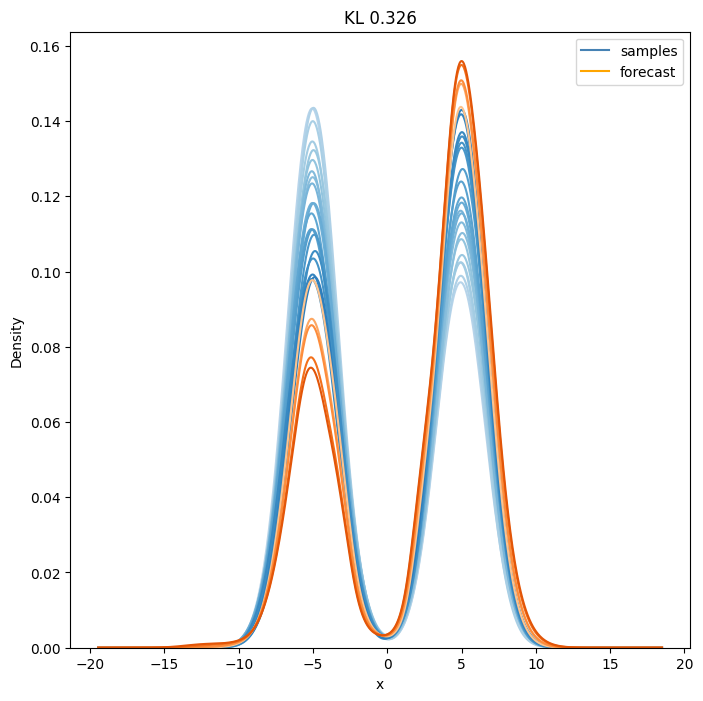

In [71]:
fpca_switch.predict(exp=True, normalize=True)

plt.figure(dpi=100, figsize=(8,8))

for n, i in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(i), color=BLUE(n))

for n, i in zip( np.linspace(0.3 ,0.7 , H_STEPS), fpca_switch.pred_f):
  plt.plot(grid_points, i, color=ORANGE(n))

kls_f = [get_kl( fpca_switch.pred_f[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_f = np.mean(kls_f)
plt.title(f'KL {np.round(kl_f, 2)}')

plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

### WGAN

In [72]:
np.random.seed(SEED)
torch.manual_seed(SEED)

wgan_switch = Wgan(data = data,
               vars = VARS,
               latent_dim = LATENT_DIM,
               condition_dim = CONDITION_DIM,
               g_hidden_layers = G_HIDDEN_LAYERS,
               g_hidden_dim = G_HIDDEN_DIM,
               g_leaky_relu = G_LEAKY_RELU,
               d_hidden_layers = D_HIDDEN_LAYERS,
               d_hidden_dim = D_HIDDEN_DIM,
               d_dropout = D_DROPOUT,
               d_leaky_relu = D_LEAKY_RELU,
               input_dim = INPUT_DIM,
               lr_gen = LR_GEN,
               lr_dis = LR_DIS,
               b1 = B1,
               b2 = B2,
               lambda_gp = LAMBDA_GP,
               n_critic = N_CRITIC,
               batch_size = BATCH_SIZE,
               device = DEVICE)

[0/2000]: loss_d: 0.362, loss_g: -0.463


15.0


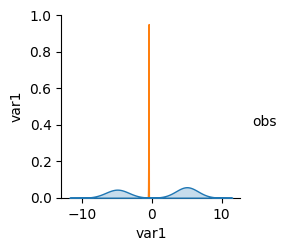

[10/2000]: loss_d: -0.208, loss_g: -0.113
[20/2000]: loss_d: -0.152, loss_g: -0.047
[30/2000]: loss_d: -0.210, loss_g: -0.158
[40/2000]: loss_d: 0.027, loss_g: -0.136
[50/2000]: loss_d: -0.062, loss_g: -0.086


11.0


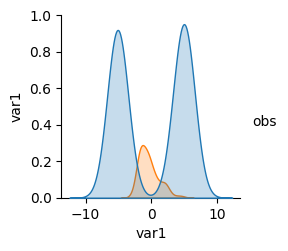

[60/2000]: loss_d: 0.097, loss_g: -0.295
[70/2000]: loss_d: 0.375, loss_g: -0.523
[80/2000]: loss_d: 0.200, loss_g: -0.327
[90/2000]: loss_d: -0.092, loss_g: -0.120
[100/2000]: loss_d: -0.057, loss_g: -0.381


11.0


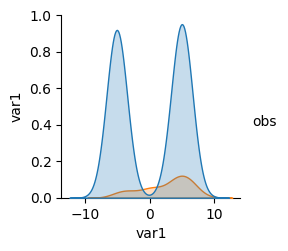

[110/2000]: loss_d: 0.099, loss_g: -0.526
[120/2000]: loss_d: 0.133, loss_g: -0.546
[130/2000]: loss_d: 0.159, loss_g: -0.553
[140/2000]: loss_d: 0.176, loss_g: -0.547
[150/2000]: loss_d: 0.195, loss_g: -0.513


6.0


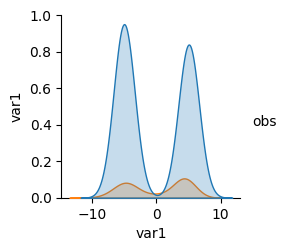

[160/2000]: loss_d: 0.195, loss_g: -0.504
[170/2000]: loss_d: 0.217, loss_g: -0.466
[180/2000]: loss_d: 0.220, loss_g: -0.458
[190/2000]: loss_d: 0.212, loss_g: -0.430
[200/2000]: loss_d: 0.235, loss_g: -0.408


1.0


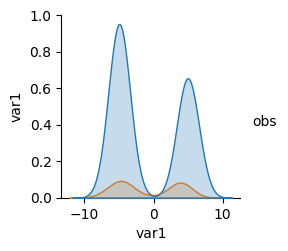

[210/2000]: loss_d: 0.223, loss_g: -0.450
[220/2000]: loss_d: 0.231, loss_g: -0.443
[230/2000]: loss_d: 0.226, loss_g: -0.449
[240/2000]: loss_d: 0.226, loss_g: -0.475
[250/2000]: loss_d: 0.233, loss_g: -0.431


19.0


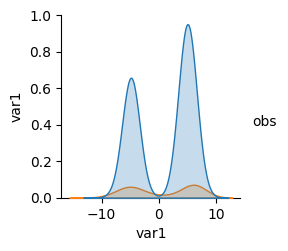

[260/2000]: loss_d: 0.237, loss_g: -0.448
[270/2000]: loss_d: 0.223, loss_g: -0.447
[280/2000]: loss_d: 0.223, loss_g: -0.513
[290/2000]: loss_d: 0.380, loss_g: -0.765
[300/2000]: loss_d: 0.124, loss_g: -0.421


15.0


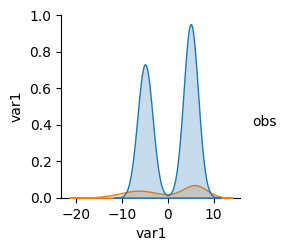

[310/2000]: loss_d: 0.256, loss_g: -0.506
[320/2000]: loss_d: 0.257, loss_g: -0.426
[330/2000]: loss_d: 0.244, loss_g: -0.516
[340/2000]: loss_d: 0.242, loss_g: -0.635
[350/2000]: loss_d: 0.224, loss_g: -0.514


11.0


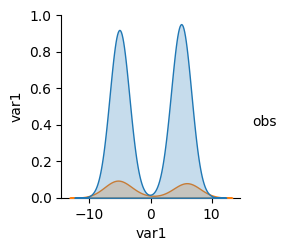

[360/2000]: loss_d: 0.211, loss_g: -0.564
[370/2000]: loss_d: 0.216, loss_g: -0.442
[380/2000]: loss_d: 0.220, loss_g: -0.424
[390/2000]: loss_d: 0.234, loss_g: -0.426
[400/2000]: loss_d: 0.225, loss_g: -0.494


0.0


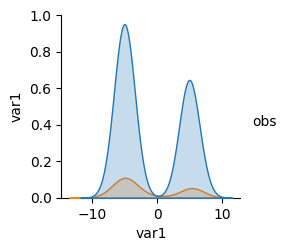

[410/2000]: loss_d: 0.204, loss_g: -0.486
[420/2000]: loss_d: 0.197, loss_g: -0.520
[430/2000]: loss_d: 0.071, loss_g: -0.439
[440/2000]: loss_d: 0.204, loss_g: -0.606
[450/2000]: loss_d: 0.171, loss_g: -0.388


17.0


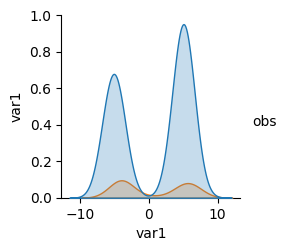

[460/2000]: loss_d: 0.250, loss_g: -0.459
[470/2000]: loss_d: 0.228, loss_g: -0.478
[480/2000]: loss_d: 0.213, loss_g: -0.460
[490/2000]: loss_d: 0.223, loss_g: -0.551
[500/2000]: loss_d: 0.220, loss_g: -0.468


7.0


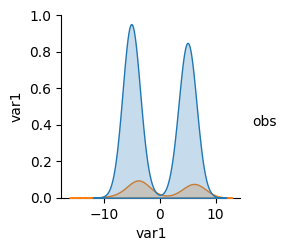

[510/2000]: loss_d: 0.218, loss_g: -0.472
[520/2000]: loss_d: 0.203, loss_g: -0.465
[530/2000]: loss_d: 0.204, loss_g: -0.514
[540/2000]: loss_d: 0.198, loss_g: -0.576
[550/2000]: loss_d: 0.218, loss_g: -0.399


9.0


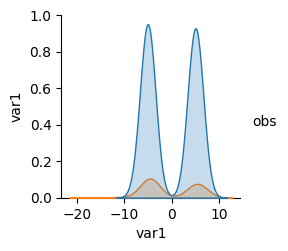

[560/2000]: loss_d: 0.184, loss_g: -0.501
[570/2000]: loss_d: 0.189, loss_g: -0.508
[580/2000]: loss_d: 0.196, loss_g: -0.518
[590/2000]: loss_d: 0.166, loss_g: -0.475
[600/2000]: loss_d: 0.320, loss_g: -0.571


5.0


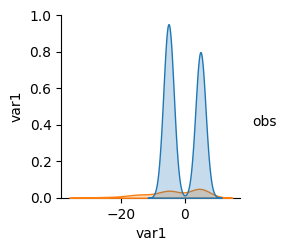

[610/2000]: loss_d: 0.330, loss_g: -0.671
[620/2000]: loss_d: 0.168, loss_g: -0.522
[630/2000]: loss_d: 0.256, loss_g: -0.573
[640/2000]: loss_d: 0.225, loss_g: -0.486
[650/2000]: loss_d: 0.209, loss_g: -0.483


18.0


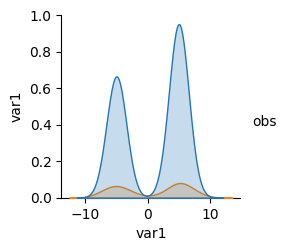

[660/2000]: loss_d: 0.204, loss_g: -0.469
[670/2000]: loss_d: 0.208, loss_g: -0.533
[680/2000]: loss_d: 0.221, loss_g: -0.538
[690/2000]: loss_d: 0.216, loss_g: -0.469
[700/2000]: loss_d: 0.225, loss_g: -0.494


1.0


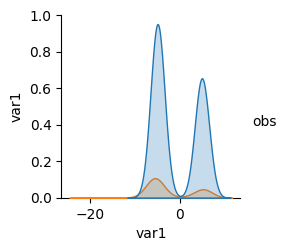

[710/2000]: loss_d: 0.229, loss_g: -0.527
[720/2000]: loss_d: 0.221, loss_g: -0.481
[730/2000]: loss_d: 0.213, loss_g: -0.525
[740/2000]: loss_d: 0.215, loss_g: -0.529
[750/2000]: loss_d: 0.205, loss_g: -0.529


10.0


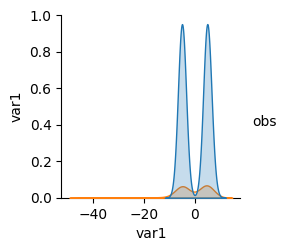

[760/2000]: loss_d: 0.222, loss_g: -0.492
[770/2000]: loss_d: 0.210, loss_g: -0.478
[780/2000]: loss_d: 0.217, loss_g: -0.498
[790/2000]: loss_d: 0.203, loss_g: -0.490
[800/2000]: loss_d: 0.212, loss_g: -0.455


4.0


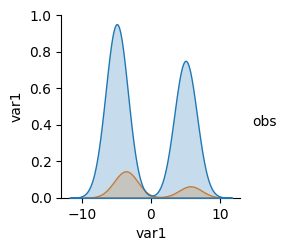

[810/2000]: loss_d: 0.214, loss_g: -0.506
[820/2000]: loss_d: 0.294, loss_g: -0.629
[830/2000]: loss_d: 0.187, loss_g: -0.520
[840/2000]: loss_d: 0.221, loss_g: -0.567
[850/2000]: loss_d: 0.226, loss_g: -0.515


8.0


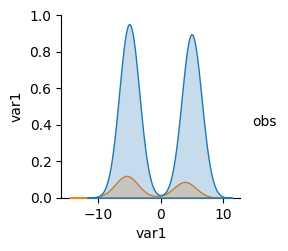

[860/2000]: loss_d: 0.191, loss_g: -0.469
[870/2000]: loss_d: 0.219, loss_g: -0.501
[880/2000]: loss_d: 0.203, loss_g: -0.518
[890/2000]: loss_d: 0.216, loss_g: -0.520
[900/2000]: loss_d: 0.225, loss_g: -0.533


5.0


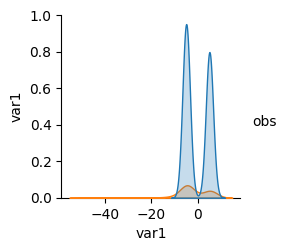

[910/2000]: loss_d: 0.211, loss_g: -0.520
[920/2000]: loss_d: 0.213, loss_g: -0.506
[930/2000]: loss_d: 0.207, loss_g: -0.498
[940/2000]: loss_d: 0.208, loss_g: -0.513
[950/2000]: loss_d: 0.206, loss_g: -0.520


17.0


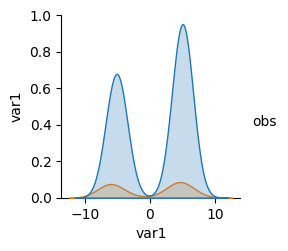

[960/2000]: loss_d: 0.230, loss_g: -0.527
[970/2000]: loss_d: 0.231, loss_g: -0.582
[980/2000]: loss_d: 0.268, loss_g: -0.592
[990/2000]: loss_d: 0.229, loss_g: -0.560
[1000/2000]: loss_d: 0.211, loss_g: -0.508


12.0


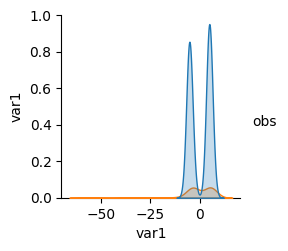

[1010/2000]: loss_d: 0.204, loss_g: -0.511
[1020/2000]: loss_d: 0.200, loss_g: -0.534
[1030/2000]: loss_d: 0.200, loss_g: -0.540
[1040/2000]: loss_d: 0.191, loss_g: -0.481
[1050/2000]: loss_d: 0.207, loss_g: -0.548


10.0


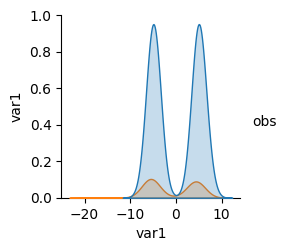

[1060/2000]: loss_d: 0.222, loss_g: -0.572
[1070/2000]: loss_d: 0.209, loss_g: -0.528
[1080/2000]: loss_d: 0.199, loss_g: -0.559
[1090/2000]: loss_d: 0.189, loss_g: -0.513
[1100/2000]: loss_d: 0.188, loss_g: -0.494


18.0


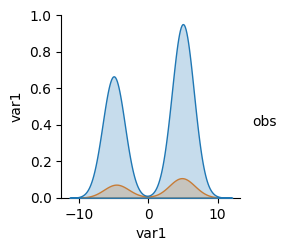

[1110/2000]: loss_d: 0.180, loss_g: -0.497
[1120/2000]: loss_d: 0.182, loss_g: -0.553
[1130/2000]: loss_d: 0.183, loss_g: -0.523
[1140/2000]: loss_d: 0.190, loss_g: -0.539
[1150/2000]: loss_d: 0.195, loss_g: -0.549


15.0


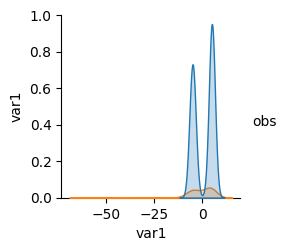

[1160/2000]: loss_d: 0.181, loss_g: -0.504
[1170/2000]: loss_d: 0.178, loss_g: -0.516
[1180/2000]: loss_d: 0.180, loss_g: -0.547
[1190/2000]: loss_d: 0.190, loss_g: -0.537
[1200/2000]: loss_d: 0.177, loss_g: -0.546


19.0


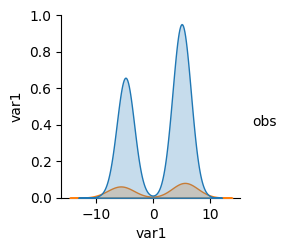

[1210/2000]: loss_d: 0.175, loss_g: -0.524
[1220/2000]: loss_d: 0.171, loss_g: -0.503
[1230/2000]: loss_d: 0.188, loss_g: -0.546
[1240/2000]: loss_d: 0.185, loss_g: -0.549
[1250/2000]: loss_d: 0.177, loss_g: -0.518


2.0


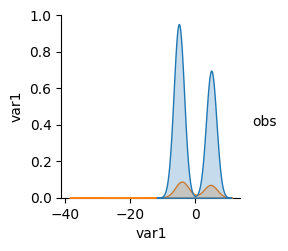

[1260/2000]: loss_d: 0.182, loss_g: -0.549
[1270/2000]: loss_d: 0.190, loss_g: -0.546
[1280/2000]: loss_d: 0.184, loss_g: -0.565
[1290/2000]: loss_d: 0.175, loss_g: -0.546
[1300/2000]: loss_d: 0.186, loss_g: -0.546


2.0


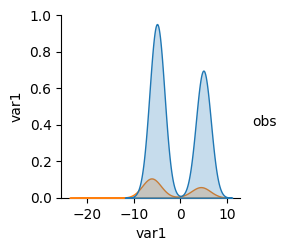

[1310/2000]: loss_d: 0.185, loss_g: -0.560
[1320/2000]: loss_d: 0.192, loss_g: -0.556
[1330/2000]: loss_d: 0.180, loss_g: -0.539
[1340/2000]: loss_d: 0.187, loss_g: -0.529
[1350/2000]: loss_d: 0.198, loss_g: -0.576


0.0


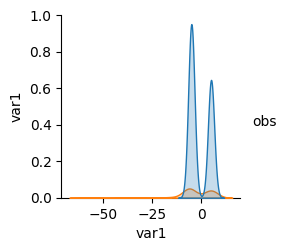

[1360/2000]: loss_d: 0.172, loss_g: -0.538
[1370/2000]: loss_d: 0.168, loss_g: -0.548
[1380/2000]: loss_d: 0.176, loss_g: -0.526
[1390/2000]: loss_d: 0.184, loss_g: -0.545
[1400/2000]: loss_d: 0.180, loss_g: -0.559


19.0


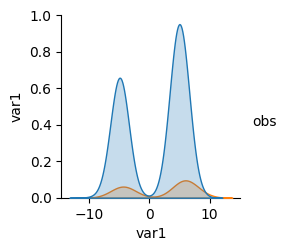

[1410/2000]: loss_d: 0.173, loss_g: -0.554
[1420/2000]: loss_d: 0.205, loss_g: -0.602
[1430/2000]: loss_d: 0.188, loss_g: -0.555
[1440/2000]: loss_d: 0.185, loss_g: -0.564
[1450/2000]: loss_d: 0.190, loss_g: -0.560


3.0


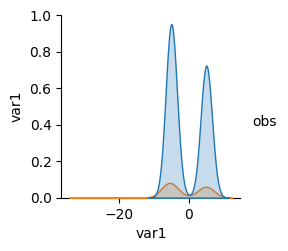

[1460/2000]: loss_d: 0.183, loss_g: -0.563
[1470/2000]: loss_d: 0.177, loss_g: -0.544
[1480/2000]: loss_d: 0.171, loss_g: -0.532
[1490/2000]: loss_d: 0.182, loss_g: -0.555
[1500/2000]: loss_d: 0.183, loss_g: -0.535


9.0


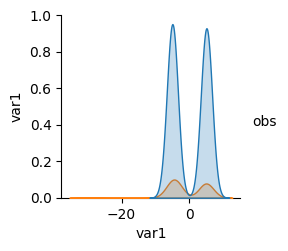

[1510/2000]: loss_d: 0.169, loss_g: -0.533
[1520/2000]: loss_d: 0.177, loss_g: -0.541
[1530/2000]: loss_d: 0.177, loss_g: -0.539
[1540/2000]: loss_d: 0.183, loss_g: -0.556
[1550/2000]: loss_d: 0.187, loss_g: -0.578


11.0


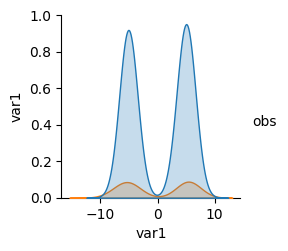

[1560/2000]: loss_d: 0.187, loss_g: -0.574
[1570/2000]: loss_d: 0.181, loss_g: -0.543
[1580/2000]: loss_d: 0.179, loss_g: -0.538
[1590/2000]: loss_d: 0.184, loss_g: -0.566
[1600/2000]: loss_d: 0.177, loss_g: -0.589


1.0


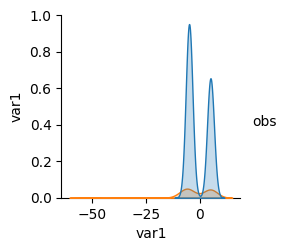

[1610/2000]: loss_d: 0.228, loss_g: -0.677
[1620/2000]: loss_d: 0.203, loss_g: -0.623
[1630/2000]: loss_d: 0.189, loss_g: -0.553
[1640/2000]: loss_d: 0.183, loss_g: -0.545
[1650/2000]: loss_d: 0.187, loss_g: -0.578


8.0


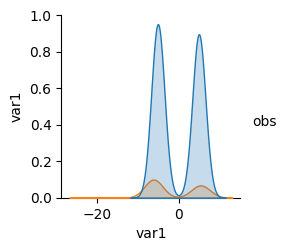

[1660/2000]: loss_d: 0.178, loss_g: -0.536
[1670/2000]: loss_d: 0.173, loss_g: -0.528
[1680/2000]: loss_d: 0.179, loss_g: -0.544
[1690/2000]: loss_d: 0.186, loss_g: -0.555
[1700/2000]: loss_d: 0.240, loss_g: -0.671


19.0


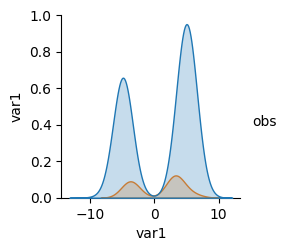

[1710/2000]: loss_d: 0.185, loss_g: -0.544
[1720/2000]: loss_d: 0.180, loss_g: -0.528
[1730/2000]: loss_d: 0.179, loss_g: -0.514
[1740/2000]: loss_d: 0.176, loss_g: -0.517
[1750/2000]: loss_d: 0.171, loss_g: -0.526


7.0


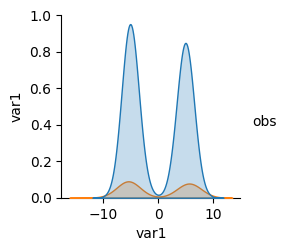

[1760/2000]: loss_d: 0.176, loss_g: -0.547
[1770/2000]: loss_d: 0.175, loss_g: -0.542
[1780/2000]: loss_d: 0.166, loss_g: -0.524
[1790/2000]: loss_d: 0.175, loss_g: -0.554
[1800/2000]: loss_d: 0.178, loss_g: -0.539


10.0


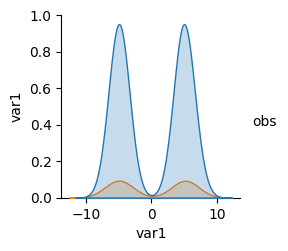

[1810/2000]: loss_d: 0.178, loss_g: -0.537
[1820/2000]: loss_d: 0.160, loss_g: -0.518
[1830/2000]: loss_d: 0.164, loss_g: -0.543
[1840/2000]: loss_d: 0.173, loss_g: -0.553
[1850/2000]: loss_d: 0.178, loss_g: -0.575


15.0


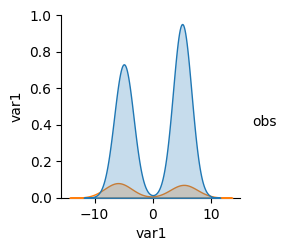

[1860/2000]: loss_d: 0.175, loss_g: -0.548
[1870/2000]: loss_d: 0.165, loss_g: -0.542
[1880/2000]: loss_d: 0.174, loss_g: -0.548
[1890/2000]: loss_d: 0.174, loss_g: -0.539
[1900/2000]: loss_d: 0.173, loss_g: -0.542


2.0


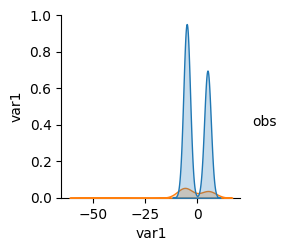

[1910/2000]: loss_d: 0.163, loss_g: -0.542
[1920/2000]: loss_d: 0.168, loss_g: -0.530
[1930/2000]: loss_d: 0.169, loss_g: -0.530
[1940/2000]: loss_d: 0.183, loss_g: -0.564
[1950/2000]: loss_d: 0.158, loss_g: -0.538


9.0


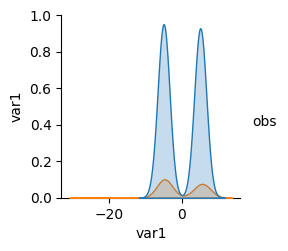

[1960/2000]: loss_d: 0.171, loss_g: -0.533
[1970/2000]: loss_d: 0.173, loss_g: -0.558
[1980/2000]: loss_d: 0.180, loss_g: -0.570
[1990/2000]: loss_d: 0.169, loss_g: -0.544


In [73]:
wgan_switch.train(n_epochs=2000)

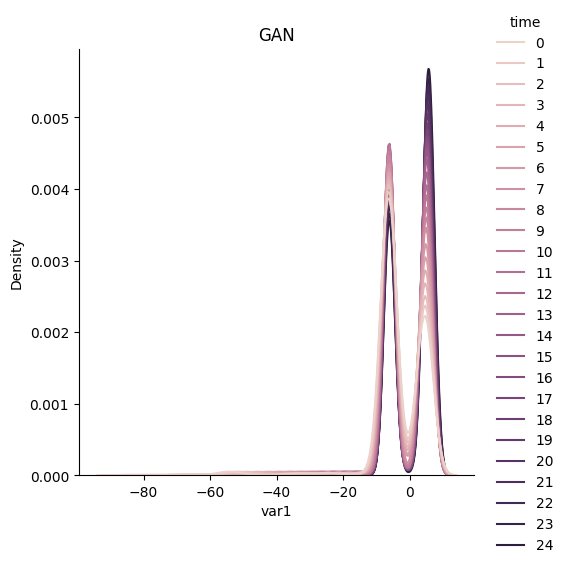

In [74]:
samples = wgan_switch.sample(time_periods=np.arange(0,T+H_STEPS), sample_size=N_SAMPLES)

sns.displot(samples, x='var1', hue='time', kind='kde')
plt.title('GAN')
plt.show()

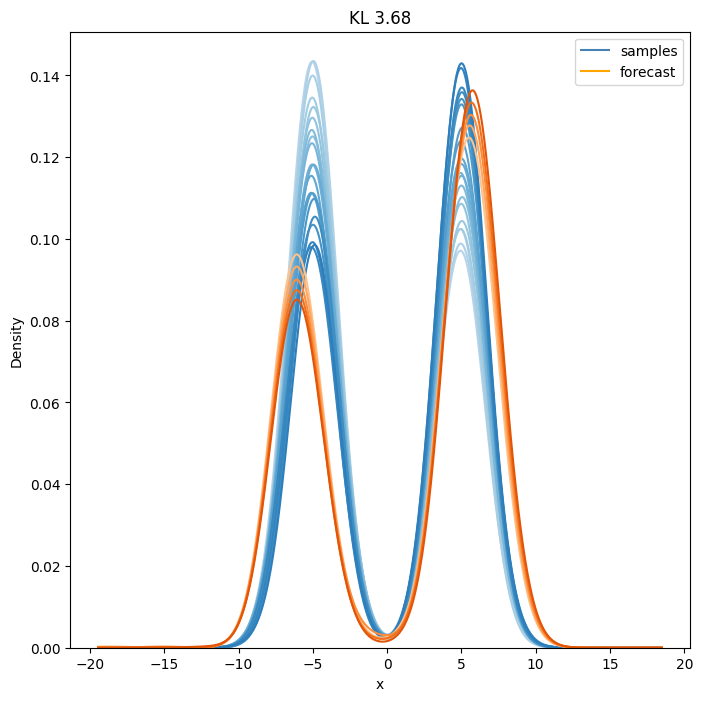

In [75]:
samples = samples[samples.time >= T].reset_index(drop=True)
kde_forecasts = get_kdes(samples, VARS[0], 'time', PREDICT_RANGE)
    
output_wgan = [kde_forecasts[i].score_samples(grid_points.reshape(-1,1)) for i in PREDICT_RANGE]

plt.figure(dpi=100, figsize=(8,8))

kls_w = [get_kl( np.exp(output_wgan[i])[1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
kl_w = np.mean(kls_w)

for n, d in zip( np.linspace(0.3 ,0.7 , T), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(n))

for n, o in zip( np.linspace(0.3 ,0.7 , H_STEPS), output_wgan):
  plt.plot(grid_points, np.exp(o), color=ORANGE(n))

plt.title(f'KL {np.round(kl_w, 2)}')
plt.plot([], [], color='steelblue', label='samples')
plt.plot([], [], color='orange', label='forecast')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

# Fin